In [3]:
import numpy as np
import pandas as pd
import math
from matplotlib import pyplot as plt
from datetime import datetime, timedelta
%matplotlib inline
import seaborn as sns
pallete = plt.get_cmap('Set2')

In [4]:
courses = pd.read_csv('courses.csv', index_col=0)
students = pd.read_csv('students.csv', index_col=0, parse_dates=['birthday'], dayfirst=True)
course_contents = pd.read_csv('course_contents.csv')
progresses = pd.read_csv('progresses.csv')
progress_phases = pd.read_csv('progress_phases.csv')

In [5]:
courses.rename(columns={'id' : 'course_id'}, inplace=True)
df_course_merge = course_contents.merge(courses, on='course_id', how='left') # Объединение course_contents и courses
progresses.rename(columns={'id' : 'progress_id'}, inplace=True)
df_progress = progress_phases.merge(progresses, on='progress_id', how='left') # Объединение progress_phases и progresses
main = df_progress.merge(df_course_merge, on=['course_id','module_number', 'lesson_number'], how='left') # Обьединие 2 датасэтов по 3 ключам


In [6]:
# Рассчет возраста студентов
students['birthday'] = pd.to_datetime(students['birthday'], errors='coerce')    
students['age'] = datetime.now() - students.birthday
students = students.dropna()
students['age'] = students['age'].apply(lambda x: int(x.days/365))


In [7]:
count_courses = len(main.course_id.unique())#  Общее количество курсов
count_moduls = main.groupby(['title','module_title'])\
    .count()\
    .reset_index()\
    .groupby('title')['module_title']\
    .count()\
    .reset_index()\
    .rename(columns={'module_title' : 'module_count'})\
    .sort_values(by='module_count') # Количество модулей на каждом курсе


In [8]:
# количество уроков в каждом модуле на каждом курсе
count_lesson = main.groupby(['field','title','module_title'])['lesson_number'].nunique() 

In [9]:
# Медианное количество уроков  в модуле на каждом курсе
count_lesson_median = count_lesson.groupby(['field', 'title']).median().reset_index().rename(columns={'lesson_number' : 'lesson_median'}).sort_values(by='lesson_median')

In [10]:
# Количество студентов на каждом курсе в каждой сфере
student_count = main.groupby(['field', 'title'])['student_id'].nunique()

In [11]:
# минимальный, максимальный, средний, медианный возраст студентов
students_age = students[(students['age'] > 16) & (students['age'] < 85)]
students_agg = students_age['age'].agg(['max', 'min', 'mean', 'median'])
students_agg 

max       76.000000
min       17.000000
mean      30.374922
median    30.000000
Name: age, dtype: float64

In [12]:
# минимальный, максимальный, средний, медианный возраст студентов на каждом курсе
students_age.rename(columns={'id' : 'student_id'}, inplace=True)
main_merge = main.merge(students_age, on='student_id', how='left')
student_age_course = main_merge.groupby('title')['age'].agg(['min', 'max', 'mean', 'median']).rename(columns={'min' : 'min_age', 'max' : 'max_age', 'mean' : 'mean_age', 'median' : 'median_age'}).sort_values(by='median_age')

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


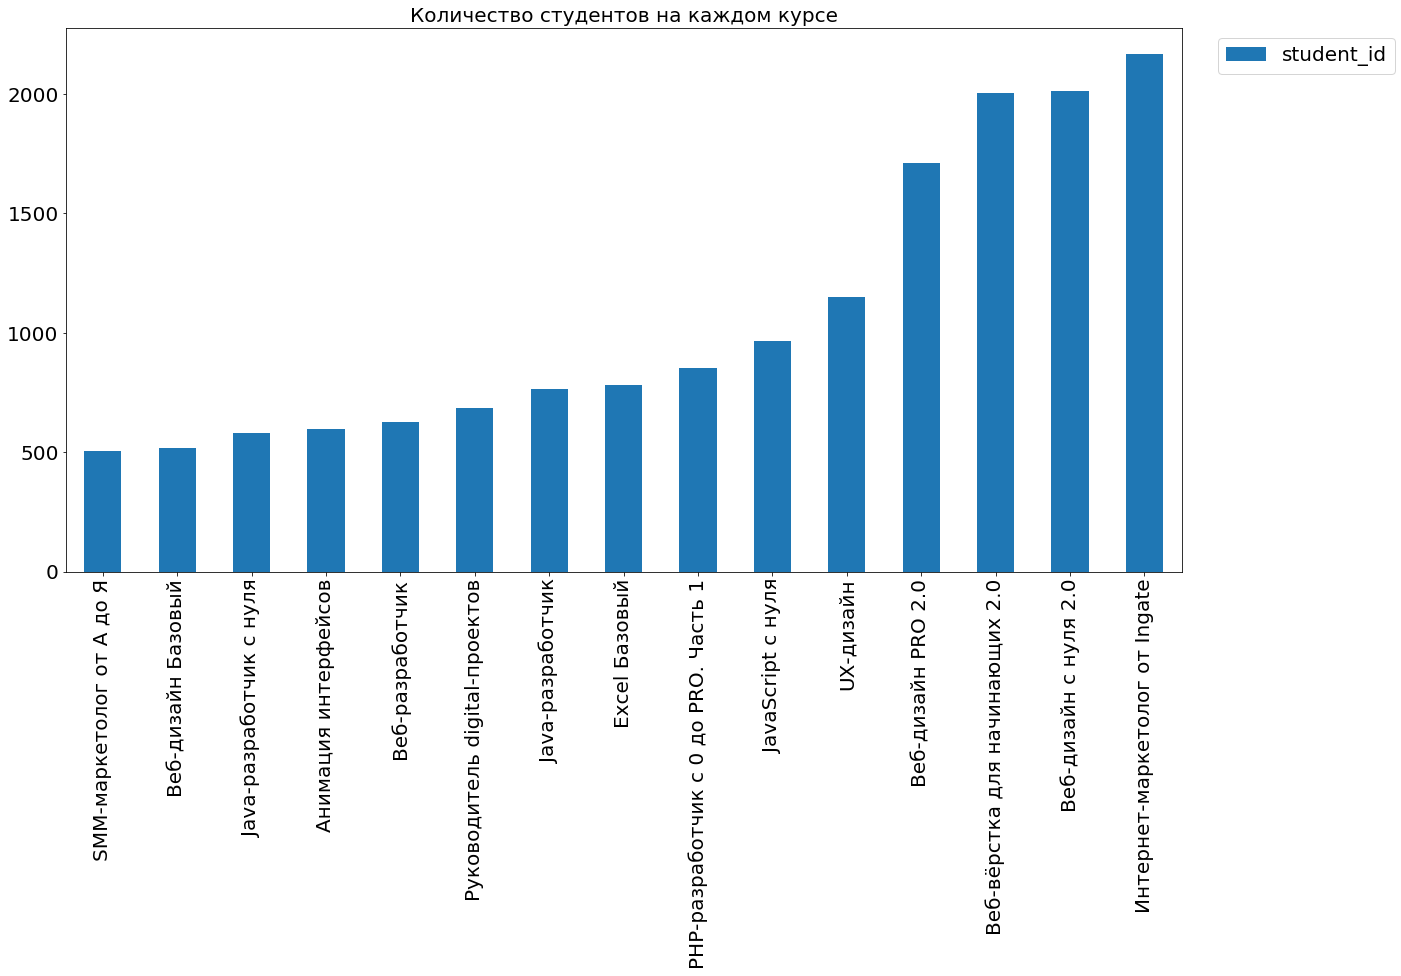

In [13]:
# группировка для построения графика "Количество студентов на каждом курсе"
students_count =  main.groupby('title')['student_id'].nunique().reset_index().sort_values(by='student_id')
# построения графика "Количество студентов на каждом курсе"
plot = students_count.plot.bar(
        figsize=(20,10)
        , fontsize=20
        , stacked=True
        , title='Количество студентов на каждом курсе')
plot.title.set_size(20)
plot.legend(loc=1, bbox_to_anchor=(1.2, 1), fontsize=20)
plot.set(ylabel=None, xlabel=None)
plot.set_xticklabels(labels=students_count['title'], rotation=90)
plt.show()

In [14]:
#группировка для построения графика "Количество студентов на каждом курсе" с указанием сфер с сортировкой датасета по сферам 
student_count_graf = student_count.unstack('field').fillna(0).sort_values(by=['Business', 'Design', 'Development', 'Marketing'])

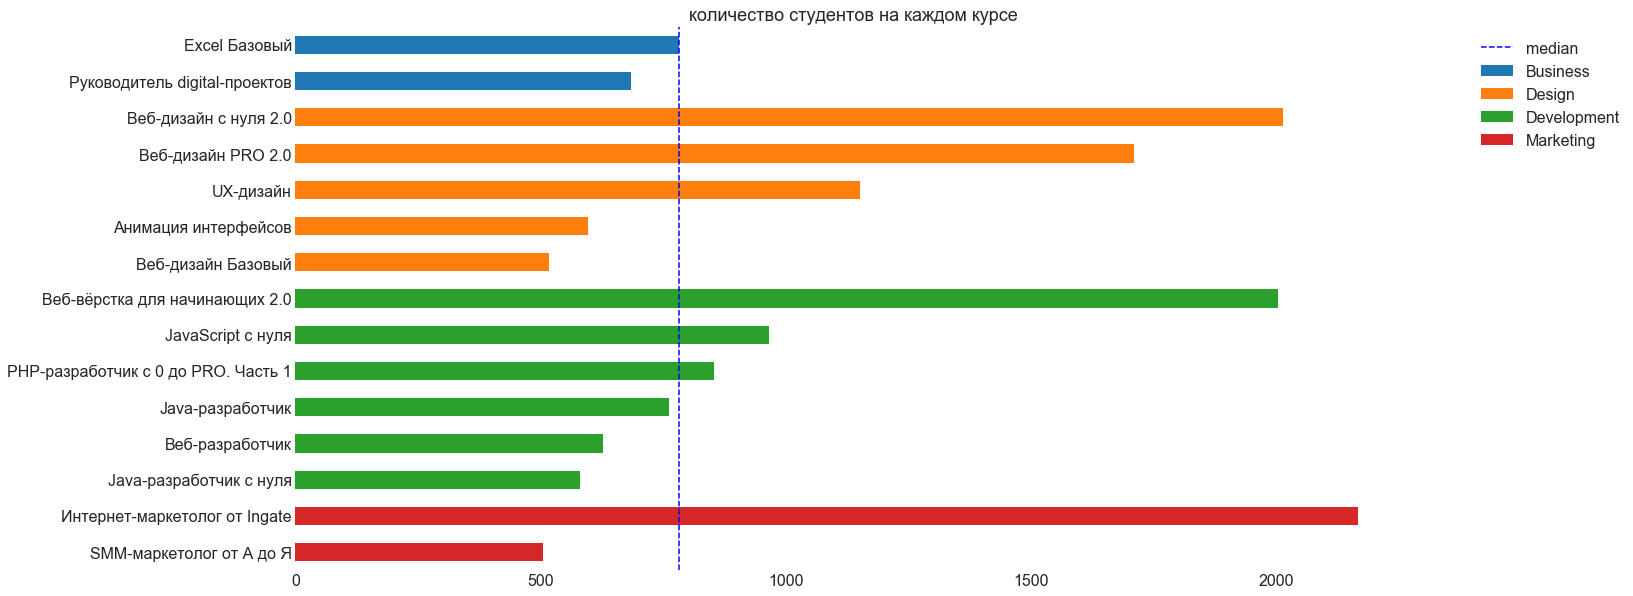

In [15]:
plt.style.use('seaborn-white') # Назначение светлой темы без сетки
med = students_count['student_id'].median() # Медиана количества студентов на всех курсах

# График количества студентов на каждом курсе с указанием сферы
plot = student_count_graf.plot.barh(
        figsize=(20,10)
        , fontsize=16
        , stacked=True
        , title='количество студентов на каждом курсе')
plot.title.set_size(18)
plot.axvline(x=med, ls='--', color='b', label='median') # Построение медианы общего количества студентов на всех курсах
plot.legend(loc=1, bbox_to_anchor=(1.2, 1), fontsize=16) # Построение легенды
plot.set(ylabel=None, xlabel=None) # Назначение осей
sns.despine(left=True, bottom=True, right=True) # Удаление рамки графика
plt.show()

### Из первичного анализа данных можно сделать следующие выводы и привести описательные характеристики:


### 1. В данных представлены образовательные курсы в количестве 15 наименований:

In [16]:
count_moduls['title']

4     PHP-разработчик с 0 до PRO. Часть 1
8          Веб-вёрстка для начинающих 2.0
0                           Excel Базовый
2                 Java-разработчик c нуля
5                SMM-маркетолог от А до Я
1                        Java-разработчик
9                      Веб-дизайн PRO 2.0
10                     Веб-дизайн Базовый
14          Руководитель digital-проектов
3                       JavaScript с нуля
13          Интернет-маркетолог от Ingate
11                  Веб-дизайн с нуля 2.0
6                               UX-дизайн
12                        Веб-разработчик
7                    Анимация интерфейсов
Name: title, dtype: object

### 2. Каждый курс имеет обучающие модули в следующем количестве:

In [17]:
count_moduls

title  module_count
4   PHP-разработчик с 0 до PRO. Часть 1             8
8        Веб-вёрстка для начинающих 2.0             8
0                         Excel Базовый             9
2               Java-разработчик c нуля             9
5              SMM-маркетолог от А до Я            11
1                      Java-разработчик            17
9                    Веб-дизайн PRO 2.0            17
10                   Веб-дизайн Базовый            17
14        Руководитель digital-проектов            17
3                     JavaScript с нуля            18
13        Интернет-маркетолог от Ingate            18
11                Веб-дизайн с нуля 2.0            19
6                             UX-дизайн            20
12                      Веб-разработчик            20
7                  Анимация интерфейсов            21

### 3. Каждый модуль обучающего курса включает в себя следующее количество уроков:

In [18]:
count_lesson

field      title                          module_title                                  
Business   Excel Базовый                   Визуализация данных Excel                         5
                                          Основной функционал Excel                         11
                                          Основной функционал Excel (продолжение)            7
                                          Сводные таблицы Excel                              5
                                          Формулы и функции Excel. Более сложные формулы     5
                                                                                            ..
Marketing  Интернет-маркетолог от Ingate  Таргетированная реклама в социальных сетях        16
                                          Управление репутацией (SERM)                      12
                                          Финальное тестирование                             1
                                          Юзабилити: раз

### 4. Медианное значение количества уроков на каждом курсе:

In [19]:
count_lesson_median

field                                title  lesson_median
12  Development                      Веб-разработчик            2.0
3        Design                 Анимация интерфейсов            3.0
5        Design                   Веб-дизайн Базовый            3.0
2        Design                            UX-дизайн            3.5
6        Design                Веб-дизайн с нуля 2.0            4.0
10  Development  PHP-разработчик с 0 до PRO. Часть 1            4.0
0      Business                        Excel Базовый            5.0
1      Business        Руководитель digital-проектов            5.0
4        Design                   Веб-дизайн PRO 2.0            5.0
13    Marketing             SMM-маркетолог от А до Я            6.0
14    Marketing        Интернет-маркетолог от Ingate            6.5
7   Development                     Java-разработчик            7.0
9   Development                    JavaScript с нуля            7.0
11  Development       Веб-вёрстка для начинающих 2.0            7.0
8   Development              Java-разработчик c нуля           13.0

#### Исходя из анализа медианного значения количества уроков на каждом курсе можно сделать вывод, что количество уроков в модуле выше в большей степени  в сфере разработки (программирования). Это объясняется трудоемкостью и наукоемкостью сферы программирования.

### 5. В данных также представлены данные о студентах, их дате рождения и месте нахождения. Путем расчетов представлен возраст студентов обучающихся на курсах:

In [20]:
students

id              city   birthday  age
id_                                                                       
7503    6c3e52be632fc50de9640147e4017dcd            Москва 1979-10-23   41
11070   35a36d90b745992b59085c8d54a072e7        Красноярск 1991-08-15   29
11756   37e8e8179295ae764524223086b0b568            Москва 1987-08-24   33
13568   fb10649db552c5f451bea45ed754d428   Санкт-Петербург 1988-07-16   32
15112   d15a188c90bb4d83957ac14de78fada4   Санкт-Петербург 1991-01-16   29
...                                  ...               ...        ...  ...
116725  3d7d520c6d739fc8cb844ebdc305743b            Москва 1990-02-21   30
117886  4bc5e1606b9596cdfe2831c2abf91153        Кошкарагай 1919-01-01  102
119731  859b49d2953c191275061f41f1ba09be         Краснодар 1990-01-03   30
122651  2ea7f5c3346ec6b9b58d7ac15fa9ad61         Хабаровск 1993-04-16   27
123277  67e72fd4f8810c633c461b01deccadb5  Санкт-Петербурге 1999-02-10   21

[11355 rows x 4 columns]

### 6. Количество студентов обучающихся на на каждом курсе в каждой сфере:

In [21]:
student_count

field        title                              
Business     Excel Базовый                           782
             Руководитель digital-проектов           685
Design       UX-дизайн                              1151
             Анимация интерфейсов                    598
             Веб-дизайн PRO 2.0                     1711
             Веб-дизайн Базовый                      518
             Веб-дизайн с нуля 2.0                  2014
Development  Java-разработчик                        763
             Java-разработчик c нуля                 581
             JavaScript с нуля                       966
             PHP-разработчик с 0 до PRO. Часть 1     854
             Веб-вёрстка для начинающих 2.0         2004
             Веб-разработчик                         628
Marketing    SMM-маркетолог от А до Я                506
             Интернет-маркетолог от Ingate          2168
Name: student_id, dtype: int64

### 7. Минимальный, максимальный, средний, медианный возраст студентов 

In [22]:
students_agg 

max       76.000000
min       17.000000
mean      30.374922
median    30.000000
Name: age, dtype: float64

#### Исходя из данных о возрасте студентов можно сделать вывод что средний медианный возраст студентов составляет 30 лет.  

### 8. Минимальный, максимальный, средний, медианный возраст студентов на каждом курсе

In [23]:
student_age_course

min_age  max_age   mean_age  median_age
title                                                                       
Веб-разработчик                         17.0     51.0  28.046180        27.0
JavaScript с нуля                       17.0     60.0  28.857962        28.0
SMM-маркетолог от А до Я                18.0     52.0  29.208819        28.0
Веб-вёрстка для начинающих 2.0          17.0     60.0  29.040582        28.0
Веб-дизайн PRO 2.0                      17.0     59.0  29.018318        28.0
Веб-дизайн Базовый                      17.0     51.0  29.013517        28.0
Веб-дизайн с нуля 2.0                   17.0     76.0  28.782001        28.0
Java-разработчик                        17.0     65.0  30.377451        29.0
Java-разработчик c нуля                 17.0     55.0  30.205011        29.0
PHP-разработчик с 0 до PRO. Часть 1     17.0     75.0  31.450719        30.0
UX-дизайн                               17.0     58.0  30.712770        30.0
Анимация интерфейсов                    17.0     51.0  30.318062        30.0
Интернет-маркетолог от Ingate           17.0     58.0  31.940785        31.0
Руководитель digital-проектов           21.0     48.0  32.505335        32.0
Excel Базовый                           17.0     61.0  33.677054        34.0

#### Анализируя данные о возрасте можно сделать вывод что на курсах "Руководитель digital-проектов" и "Excel базовый" Максимальный медианный возраст студентов составляет 34 и 33 года соответствено. Это свидетельствует о том что студенты этих курсов уже приобрели какую либо специальность ранее и сейчас приобретают навыки  анализа информации через Excel в  случае с курсом "Excel базовый" или навыки руководства  именно digital-проекта в случае с курсом "Руководитель digital-проектов". Студенты этих курсов уже являются руководителями или собираются ими стать. И тот и другой курс относится к сфере управления.  В тоже время минимальный медианный возраст студентов относится к сфере программирования в большей степени, так как эти курсы готовят именно специалистов в области программирования

### 9. График отражающий количество студентов на каждом курсе.

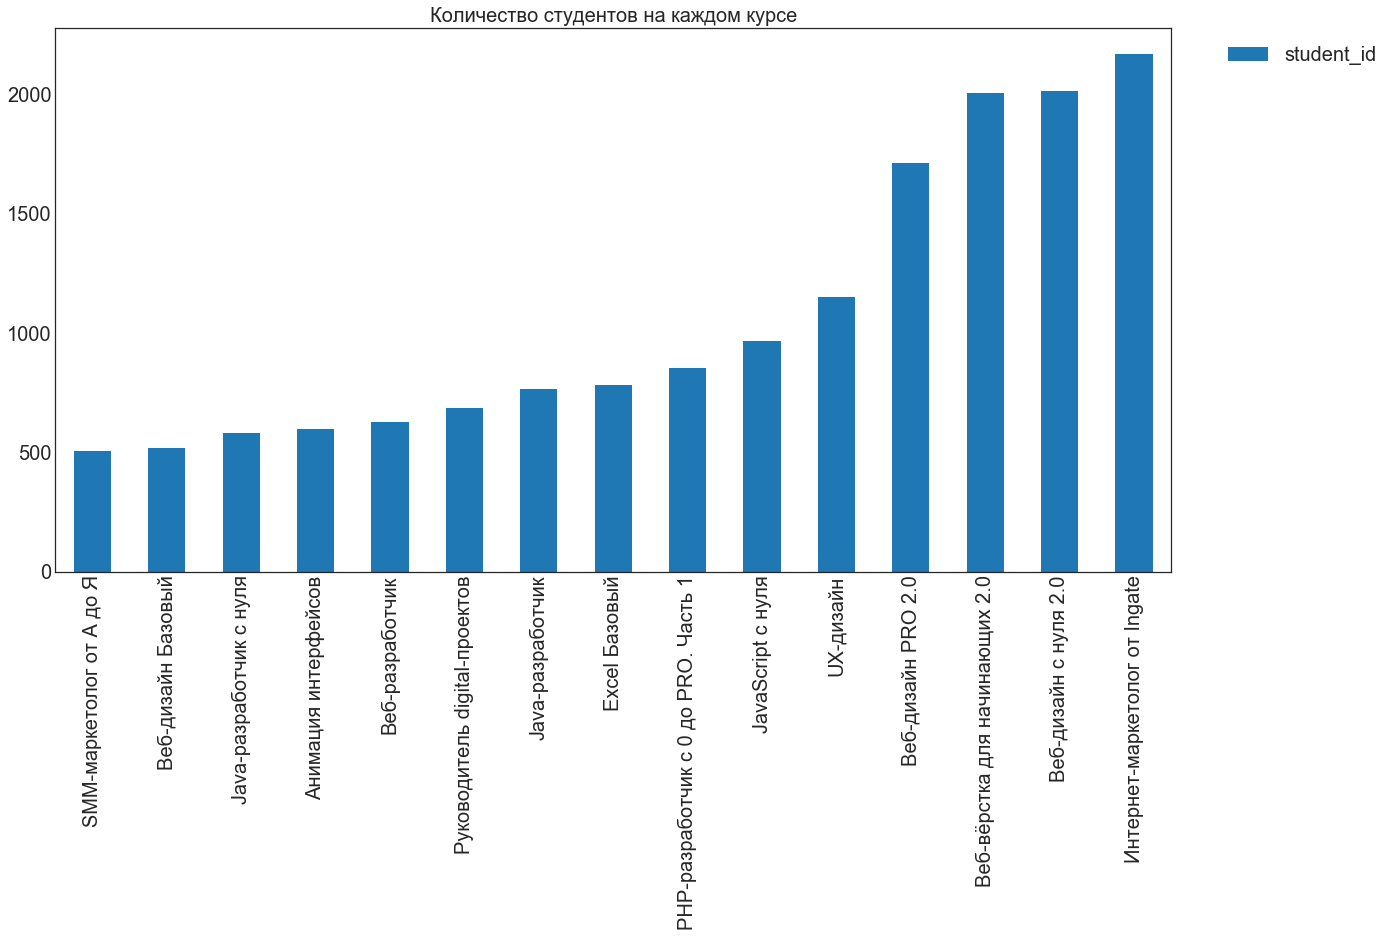

In [24]:
students_count =  main.groupby('title')['student_id'].nunique().reset_index().sort_values(by='student_id')
plot = students_count.plot.bar(
        figsize=(20,10)
        , fontsize=20
        , stacked=True
        , title='Количество студентов на каждом курсе')
plot.title.set_size(20)
plot.legend(loc=1, bbox_to_anchor=(1.2, 1), fontsize=20)
plot.set(ylabel=None, xlabel=None)
plot.set_xticklabels(labels=students_count['title'], rotation=90)
plt.show()

In [25]:
students_count

title  student_id
5              SMM-маркетолог от А до Я         506
10                   Веб-дизайн Базовый         518
2               Java-разработчик c нуля         581
7                  Анимация интерфейсов         598
12                      Веб-разработчик         628
14        Руководитель digital-проектов         685
1                      Java-разработчик         763
0                         Excel Базовый         782
4   PHP-разработчик с 0 до PRO. Часть 1         854
3                     JavaScript с нуля         966
6                             UX-дизайн        1151
9                    Веб-дизайн PRO 2.0        1711
8        Веб-вёрстка для начинающих 2.0        2004
11                Веб-дизайн с нуля 2.0        2014
13        Интернет-маркетолог от Ingate        2168

#### Анализируя график можно сделать вывод что больше всего студентов учаться на курсах "Веб-дизайн с нуля 2.0" и "Интернет-маркетолог от Ingate". Это обусловлено популярностью направлений , возможно более активной рекламой данных курсов,  известностью компании Ingate   и  возможность применения практических навыков приобретенных на курсе непосредственно в своей деятельности. На курсах "SMM-маркетолог от А до Я" и "Веб-дизайн базовый" обучается меньше всего студентов. Возможно эти курсы были недостаточно полно анонсированны будущим студентам, или есть курсы более информативные но с меньшей ценой или меньшей продолжительностью например в случае с курсом "Веб-дизайн pro 2.0". Возможно у конкурентов есть подобные направления курсов с более привлекательными условиями.

### 10. График "Количество студентов на каждом курсе" с указанием сфер с сортировкой  по сферам обучения

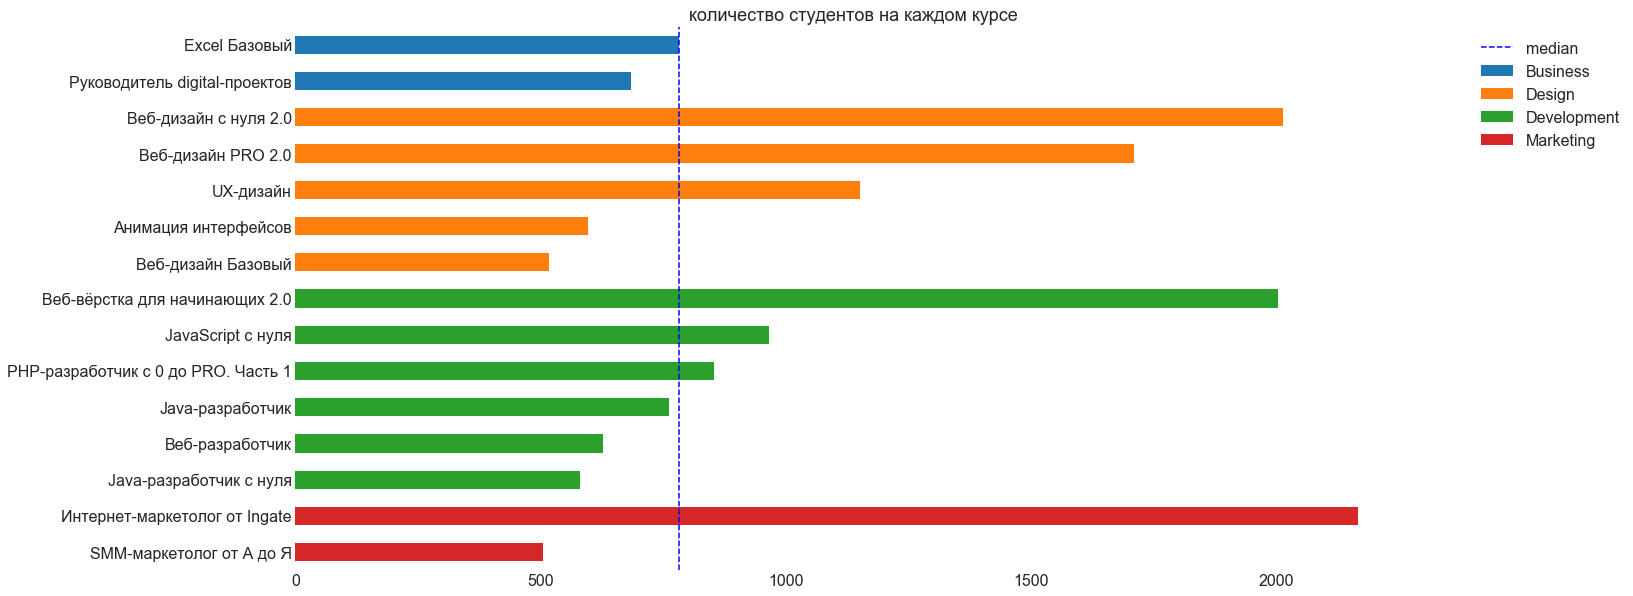

In [26]:
student_count_graf = student_count.unstack('field').fillna(0).sort_values(by=['Business', 'Design', 'Development', 'Marketing'])
plt.style.use('seaborn-white')
med = students_count['student_id'].median()
plot = student_count_graf.plot.barh(
        figsize=(20,10)
        , fontsize=16
        , stacked=True
        , title='количество студентов на каждом курсе')
plot.title.set_size(18)
plot.axvline(x=med, ls='--', color='b', label='median') # Построение медианы общего количества студентов на всех курсах
plot.legend(loc=1, bbox_to_anchor=(1.2, 1), fontsize=16) # Построение легенды
plot.set(ylabel=None, xlabel=None) # Назначение осей
sns.despine(left=True, bottom=True, right=True) # Удаление рамки графика
plt.show()




In [27]:
student_count_graf

field                                Business  Design  Development  Marketing
title                                                                        
SMM-маркетолог от А до Я                  0.0     0.0          0.0      506.0
Интернет-маркетолог от Ingate             0.0     0.0          0.0     2168.0
Java-разработчик c нуля                   0.0     0.0        581.0        0.0
Веб-разработчик                           0.0     0.0        628.0        0.0
Java-разработчик                          0.0     0.0        763.0        0.0
PHP-разработчик с 0 до PRO. Часть 1       0.0     0.0        854.0        0.0
JavaScript с нуля                         0.0     0.0        966.0        0.0
Веб-вёрстка для начинающих 2.0            0.0     0.0       2004.0        0.0
Веб-дизайн Базовый                        0.0   518.0          0.0        0.0
Анимация интерфейсов                      0.0   598.0          0.0        0.0
UX-дизайн                                 0.0  1151.0          0.0        0.0
Веб-дизайн PRO 2.0                        0.0  1711.0          0.0        0.0
Веб-дизайн с нуля 2.0                     0.0  2014.0          0.0        0.0
Руководитель digital-проектов           685.0     0.0          0.0        0.0
Excel Базовый                           782.0     0.0          0.0        0.0

   #### На основании данного графика можно сделать выводы о количестве студентов в каждой сфере обучения. В каждой сфере есть курсы-лидеры и курсы-аутсайдеры. Расмотрим сферу управления. Представленные в этой сфере курсы предназначены уже для состоявшихся или начинающих руководителей который хотят поднять свои компетенции на более высокий уровень. И продюссерам данных курсов стоит обратить внимание на возраст аудитории этих курсов и направить рекламную деятелность на данную группу. 
   #### Сфера дизайна представлена пятью курсами. Два курса-лидера в данном направлении обусловлены улушенными версиями предыдущих курсов, где уже проведена работа по коррекции курса с учетом пожеланий студентов. Курс "UX-дизайн" и "Анимация интерфейсов" являются частными курсами более больших курсов-профессий и несколько наименее востребованы как отдельные единицы, так как скорее всего их стоимость несколько завышена в рамках отделных курсов. Необходимо пересмотреть их стоимость или поднять популярность этих курсов с помощьюособой рекламной деятельности
   #### Сфера  разработки представлена шестью курсами лидером среди которых является "Веб-вёрстка для начинающих 2.0". Это обусловлено популярностью направления в целом и курсом в частности. Также студентам интересны курсы по PHP-разработке и java Script. Курсы " Java -разработчик" , "Веб-разработчик ", "Java -разработчик с нуля " менее популярны у студентов так как также являются частью более обьемных курсов-профессий. необходимо пересмотреть их стоимость и позиционирование.
   #### Сфера маркетинга представлена двумя курсами. Лидером является курс  "Интернет-маркетолог от Ingate". Это объясняется популярностью направления, известностью партнера по созданию курса компании Ingate, наполненностью курса практическими инструментами маркетинга, которые можно сразу применить в своей деятельности,  отзывами о курсе окончивших его студентов. Курс " SMM-маркетолог от А до Я" также является частью курса-профессии и менее востребован как отдельная единица. Необходимо пересмотреть стоимость курса,  наполненность курса необходимыми инструментами SMM-маркетинга, возможно сделать upgrade курса и пересмотреть рекламную компанию для повышения потребительской привлекательности.

    


## 2. Расчет потенциальной нагрузки на преподавателей

##### 1. Рассчитать прирост студентов на каждом курсе в каждом месяце за всю историю (каждый месяц в диапазоне от марта 2016 до июля 2019 включительно). Считать дату начала прохождения курса студентом по дате начала первой домашней работы.

In [28]:
# Определение модуля в котором была первая домашняя работа (для каждого курса)
main_hw = main[main['is_homework'] == True].groupby('title')['module_number'].min()
main_hw = main_hw.to_frame().reset_index()
main_hw

title  module_number
0                         Excel Базовый              1
1                      Java-разработчик              1
2               Java-разработчик c нуля              1
3                     JavaScript с нуля              1
4   PHP-разработчик с 0 до PRO. Часть 1              1
5              SMM-маркетолог от А до Я              1
6                             UX-дизайн              1
7                  Анимация интерфейсов              1
8        Веб-вёрстка для начинающих 2.0              1
9                    Веб-дизайн PRO 2.0              1
10                   Веб-дизайн Базовый              3
11                Веб-дизайн с нуля 2.0              1
12                      Веб-разработчик              1
13        Интернет-маркетолог от Ingate              1
14        Руководитель digital-проектов              1

In [29]:
# Создаем датафрэйм с условиями наличия домашней работы и номера модуля в котором была сделана первая домашняя работа
main_cond_1 = main[(main['is_homework'] == True) & (main['module_number'] == 1)]
# Создаем датафрэйм с условиями наличия домашней работы и  номера модуля в котором была сделана первая домашняя работа в этом курсе
main_cond_2 = main[(main['is_homework'] == True) & (main['module_number'] == 3) & (main['title'] == 'Веб-дизайн Базовый')]
# Объединение датафрэймов
main_df = pd.concat([main_cond_1, main_cond_2])
main_df                    

progress_id  module_number  lesson_number status  \
4       a387ab916f402cb3fbfffd29f68fd0ce              1              6   done   
17      a97393fe164b448e7231c07d48c82f9e              1              7   done   
82      000962791295398b5ec7bc24f05269ac              1              9   done   
111     2041e707f186990fef40d6e5d869ddf6              1              8   done   
144     81fb8b7412a483355d02d32987aaba6e              1              3  start   
...                                  ...            ...            ...    ...   
346896  2d13d2cafca13d8492746ba660343a5d              3              2   done   
347910  cf030a2bee2ab5bee9cdddfc9d7ee3d3              3              2   done   
348958  be2124178eba6a83bc926a3f5a94ac7b              3              2   done   
349299  f33b2f64c486ab69ab8f71b96c3b1b28              3              2   done   
349928  37a32fb74bb042cd0cbb70fbd00754ed              3              2   done   

                           start_date                    finish_date  \
4       2018-06-21 19:10:36.957891+00  2018-06-28 15:59:25.320418+00   
17      2018-02-19 12:30:34.638431+00  2018-02-20 09:16:50.297369+00   
82      2018-08-28 06:07:40.775809+00  2018-09-13 10:25:35.378681+00   
111     2019-02-26 15:18:47.304803+00  2019-03-03 13:48:32.212435+00   
144     2018-07-07 10:13:37.089749+00                            NaN   
...                               ...                            ...   
346896   2018-04-23 09:34:12.83844+00  2018-04-23 20:56:20.359535+00   
347910  2019-01-25 06:52:38.981996+00  2019-02-10 20:11:44.100291+00   
348958  2018-05-21 03:45:58.840901+00  2018-06-06 14:50:48.696675+00   
349299  2018-02-20 14:00:46.002916+00  2018-02-26 15:59:37.008248+00   
349928   2018-06-15 18:31:45.43994+00  2018-06-25 21:39:35.551188+00   

                              student_id                         course_id  \
4       768c2987a744c51ce64a5993a2a94eaf  c9fcb746d51e41bc5a217002d081454b   
17      f69e2707b7ba94d49ca03ea9ed52ea5d  bf27a4bf4ada4c756451703ea62a914f   
82      fcd7b6853c2582372980dd6af56d3bdc  e3a0df907589d56692b5cb561fd90d87   
111     84d2010cc192eb3b4d73477cca78845b  dad6f6ffc086caa89e2f40c28a9c7490   
144     3dac07629e8e0b23af6654f6deda91c4  04ba6d0b40670c43a209141fa01fa784   
...                                  ...                               ...   
346896  5338d5a2b6089a8482753b71a5ee2b34  17013cd19d25cb3f28dc1b2683721bb9   
347910  6265b478eae59b306e64cc20c35e0e77  17013cd19d25cb3f28dc1b2683721bb9   
348958  d56ad68b0ac537fa8628317390765b02  17013cd19d25cb3f28dc1b2683721bb9   
349299  97f3a8a2c90fe0f11bc105a71afc6cec  17013cd19d25cb3f28dc1b2683721bb9   
349928  bce2deb6ead4d934d90693875e59e912  17013cd19d25cb3f28dc1b2683721bb9   

                                             module_title     lesson_title  \
4                 Специализация и личное позиционирование  Домашняя работа   
17      Введение в интернет-маркетинг: цели, инструмен...  Домашняя работа   
82                            Введение и первый результат  Домашняя работа   
111          Профессия дизайнера в эпоху цифровых перемен  Домашняя работа   
144     Введение в Motion Design. Тренды, разновидност...  Домашняя работа   
...                                                   ...              ...   
346896   Базовые знания о типографике. Практика Photoshop  Домашняя работа   
347910   Базовые знания о типографике. Практика Photoshop  Домашняя работа   
348958   Базовые знания о типографике. Практика Photoshop  Домашняя работа   
349299   Базовые знания о типографике. Практика Photoshop  Домашняя работа   
349928   Базовые знания о типографике. Практика Photoshop  Домашняя работа   

                                lesson_token  is_video  is_homework  \
4       43e1fbdd-1ee9-4ed5-a577-4dadd80c02b3     False         True   
17      148dd02b-c203-4d35-a8a5-daf33fc02a82     False         True   
82      d5a66366-cf9e-49b9-9a09-77a29706a142     False         True   
111     474607cc-0b1b-405d-b391-2

In [30]:
# Добавление столбца для расчета по месяцам
main_df['month'] = pd.to_datetime(main_df['start_date']).dt.to_period('M')
main_df = main_df.sort_values(by='month')
main_df['month'] = main_df['month'].astype(str)
# Вспомогательный датафрейм с датами
date = pd.date_range('2016-03-1', periods=41, freq='M')
date = date.to_frame().reset_index()
date.drop(['index'], axis='columns',inplace=True)
date.columns = ['month']
date['month'] = pd.to_datetime(date['month'].astype(str)).dt.to_period('M')
date['month'] = date['month'].astype(str)
# Группировка датафрейма для построение графика
main_dat = main_df.groupby(['title','month'])['student_id'].count().to_frame().reset_index().rename(columns={'student_id' : 'student_count'})
main_dat_drop = main_dat.drop(['student_count'], axis='columns')
main_dat_drop = main_dat_drop.sort_values('month')
main_dat_drop

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/arrays/datetimes.py:1102: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  UserWarning,


title    month
184                Веб-разработчик  2016-03
85                       UX-дизайн  2016-11
152             Веб-дизайн Базовый  2017-03
185                Веб-разработчик  2017-04
86                       UX-дизайн  2017-04
..                             ...      ...
57               JavaScript с нуля  2019-07
223  Интернет-маркетолог от Ingate  2019-07
183          Веб-дизайн с нуля 2.0  2019-07
204                Веб-разработчик  2019-07
243  Руководитель digital-проектов  2019-07

[244 rows x 2 columns]

#### 2. Построение line-graph с приростом студентов в каждом месяце для каждого курса. 15 графиков. Графики должны иметь заголовки, оси должны быть подписаны. Ticks нужно развернуть так, чтобы они были читаемы.

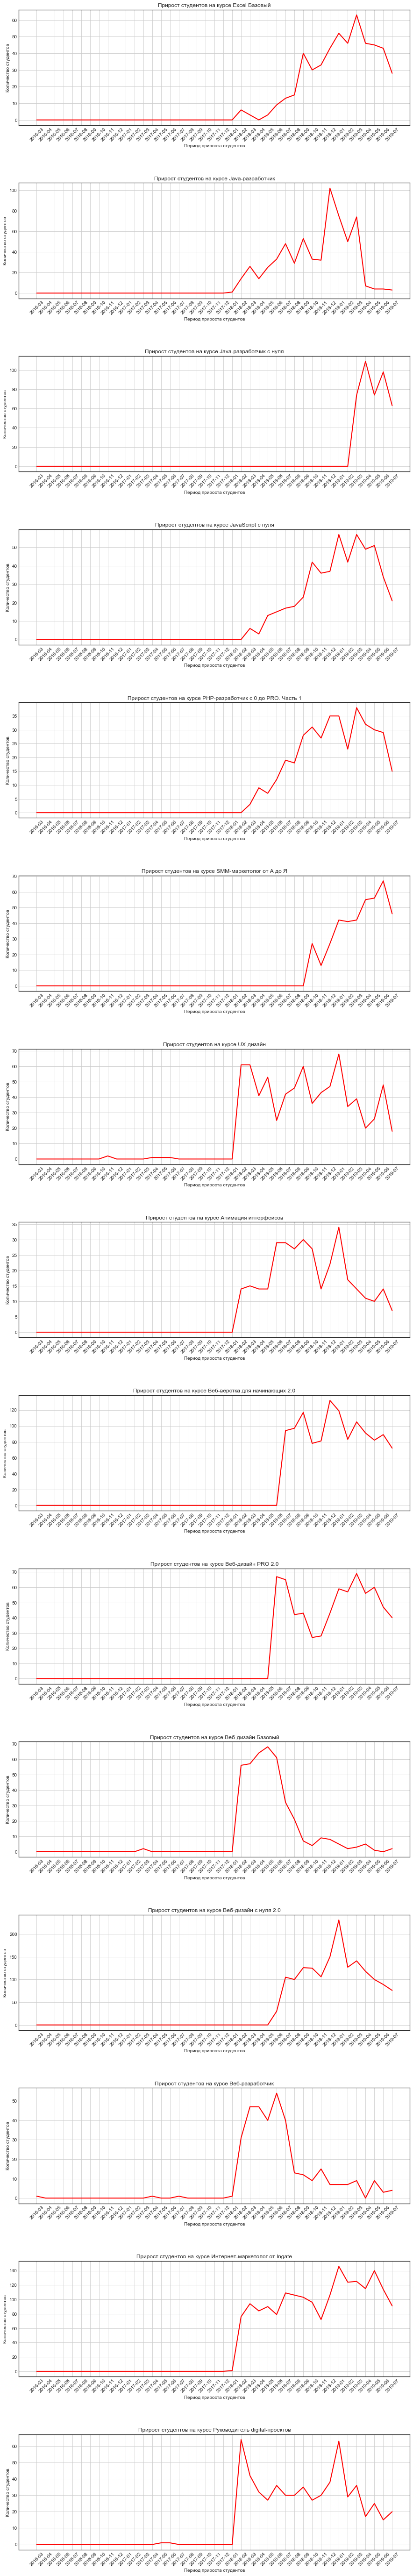

In [31]:
# Построение графика прироста студентов по месяцам
fig, axes = plt.subplots(15, 1, figsize=(15, 100))
n = 0
for name, data in main_dat_drop.groupby('title'):
    # Объединение сгруппированного датафрэйма с датами для сохранения нулевых значений прироста
    data = data.merge(date, on='month', how='outer').fillna(name).sort_values(by='month')
    data = data.merge(main_dat, on=['title','month'], how='outer')
    # Выборка по названию курса 
    data = data[data['title'] == name].fillna(0)
    # Построение графика
    axes[n].plot(data.month, data.student_count, linewidth=2, color='red') 
    axes[n].set_xlabel('Период прироста студентов')
    axes[n].set_ylabel('Количество студентов')
    axes[n].set_title('Прирост студентов на курсе {}'.format(name))
    axes[n].set_xticklabels(data.month, rotation=45)
    axes[n].set_xticks(data.month)
    axes[n].grid()
    n+=1
plt.subplots_adjust(wspace=0, hspace=0.5)
plt.show()

#### 2. На основании первого пункта построить line-graph с несколькими линиями, отражающими прирост студентов в каждом месяце для каждого курса. 15 линий на графике. Ticks нужно развернуть так, чтобы они были читаемы. График должен иметь заголовок. Ось, отражающая прирост, должна быть подписана. Линия для каждого курса должна иметь свой цвет (нужна легенда). Рамок у графика быть не должно ⭐

In [32]:
main_dat = main_dat.sort_values(by='month')

In [33]:
# сводная таблица по датафрейму с сохранением нулевых значений для построения корректного графика
piv = main_dat.pivot_table(index='month', columns='title', values='student_count').fillna(0)

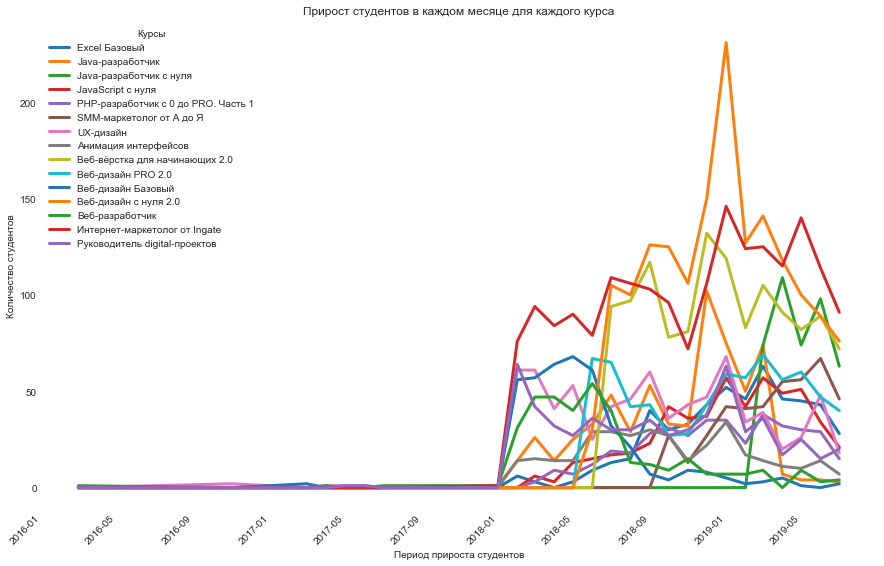

In [34]:
piv.index = pd.to_datetime(piv.index)
# Построение графика
piv = piv.loc['2016-03':]
piv.plot(figsize=(15,10), linewidth=3)
plt.xlabel('Период прироста студентов')
plt.ylabel('Количество студентов')
plt.xticks(rotation=45)
plt.title('Прирост студентов в каждом месяце для каждого курса')
plt.legend(loc='upper left', title='Курсы')
plt.box(False) # Удаление рамки
plt.show()

### На основании построенных графиков можно сделать следующие выводы о приросте студентов на каждом курсе:
1. Прирост студентов на каждом курсе неравномерный
2. Такие курсы как Excel Базовый, Java-разработчик,Java Script, Java Script c 0, PHP-разработчик с 0 до PRO имеют плавную тенденцию прироста, остальные курсы имеют резкий прирост студентов, что обусловлено активной рекламой и "подогревом " будущих студентов в соц.сетях и интернете. На момент высокого роста высока и актуальность онлайн-образования и направления обучения(направления курсов). 
3. Также на различных курсах наблюдается и различный прирост в натуральном выражении. На курсе Анимация Интерфейсов, Excel Базовый  и PHP-разработчик с 0 до PRO наблюдается низкий прирост студентов( в среднем 30 в месяц). В то же время такие курсы как Веб вертска для начинающих, Java-разработчик с 0, Java-разработчик и Интернет -маркетолг от Ingate имеют максимальный прирост более 100 студентов в месяцю Это обусловлено актуальностью курсов, их прикладной применимостью и популярностью  направления обучения. 
4. Каждый курс в той или иной мере имеет тенденцию к снижению прироста студентов с тесением определенного времени. На таких курсах как Java-разработчик, Веб-дизайн Базовый, Веб -разработчик прирост падает практически до нуля в определенные моменты. Это обьясняется тем, что у каждого курса есть определенный жизненный цикл и " срок годности". Во время предоставления курса необходимо  собирать  обратную связь о курсе, и на основе этих данных готовить новый продукт- более всеобьемлющий и интересный курс. Улучшенную версию прежнего курса. И эта новая версия при правильной рекламной компании и маркетинге в целом  будет пользоваться повышенным спросом у потребителя. А старый курс уже не пользуется такой популярностью и прирост студентов падает.



#### 4. Рассчитать количество прогрессов по выполнению домашних работ в каждом месяце за всю историю (каждый месяц в диапазоне от марта 2016 до июля 2019 включительно) для каждого курса. Учитывать, что выполнение домашнего задания может перетекать из одного месяца в другой (такие дз надо включать в общее число прогрессов для всех месяцев, которые покрывает срок выполнения этих дз)

In [35]:
main_merge_hw = main[main['is_homework'] == True]
progress_hw = main_merge_hw[['title','start_date', 'finish_date', 'progress_id']]
# Замена пропусков в столбце 'finish_date' для учета незавершенных домашних работ, так как незавершенные домашние работы
# также являются нагрузкой на преподавателя
progress_hw['finish_date'] = progress_hw['finish_date'].fillna('2019-07-31 00:00:00.00+00')
# Добавление столбца с месяцем начала выполнения домашней работы
progress_hw['month_start'] = pd.to_datetime(progress_hw['start_date']).dt.to_period('M')
# Добавление столбца с месяцем окончания выполнения домашней работы
progress_hw['month_finish'] = pd.to_datetime(progress_hw['finish_date']).dt.to_period('M')
progress_hw = progress_hw.sort_values(by=(['month_start','month_finish']))
progress = progress_hw[['title','month_start','month_finish','progress_id']]
progress_hw

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/opt/anaconda3/lib/python3.7/site-packages/pandas/core/arrays/datetimes.py:1102: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  UserWarning,
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCo

title                     start_date  \
215410                Веб-разработчик         2016-03-17 10:10:13+00   
215412                Веб-разработчик         2016-03-15 17:39:14+00   
215414                Веб-разработчик         2016-03-18 17:56:32+00   
215416                Веб-разработчик         2016-03-16 16:52:18+00   
215417                Веб-разработчик         2016-03-24 05:25:49+00   
...                               ...                            ...   
350555          Веб-дизайн с нуля 2.0  2019-07-15 21:56:18.295747+00   
350615          Веб-дизайн с нуля 2.0  2019-07-02 09:23:36.462711+00   
350618          Веб-дизайн с нуля 2.0  2019-07-12 12:00:25.276113+00   
350622          Веб-дизайн с нуля 2.0  2019-07-10 08:02:10.115602+00   
350667  Интернет-маркетолог от Ingate  2019-07-02 21:06:01.673478+00   

                          finish_date                       progress_id  \
215410         2016-03-18 07:26:45+00  fd66f592001bd159efcbd014cf5ed608   
215412         2016-03-15 18:30:22+00  fd66f592001bd159efcbd014cf5ed608   
215414         2016-03-20 16:15:24+00  fd66f592001bd159efcbd014cf5ed608   
215416         2016-03-17 05:42:13+00  fd66f592001bd159efcbd014cf5ed608   
215417         2016-03-26 12:07:21+00  fd66f592001bd159efcbd014cf5ed608   
...                               ...                               ...   
350555      2019-07-31 00:00:00.00+00  2f9742d87b5c9cd7dc1a37c406084aaa   
350615  2019-07-02 18:42:34.847754+00  a815345d620aefc617d9deb6d9c4f804   
350618      2019-07-31 00:00:00.00+00  a815345d620aefc617d9deb6d9c4f804   
350622   2019-07-11 12:33:37.49494+00  a815345d620aefc617d9deb6d9c4f804   
350667  2019-07-16 13:32:41.738515+00  ea9c93865c1de54a5079b7ae71c88683   

       month_start month_finish  
215410     2016-03      2016-03  
215412     2016-03      2016-03  
215414     2016-03      2016-03  
215416     2016-03      2016-03  
215417     2016-03      2016-03  
...            ...          ...  
350555     2019-07      2019-07  
350615     2019-07      2019-07  
350618     2019-07      2019-07  
350622     2019-07      2019-07  
350667     2019-07      2019-07  

[54478 rows x 6 columns]

In [36]:
progress['month_start'] = progress['month_start'].astype(str)
progress['month_finish'] = progress['month_finish'].astype(str)
# Создание столбцов каждого месяца заданного периода
for date in pd.date_range("2016-03-01", "2019-07-01", freq="MS"):
    new_column = str.format("{}-{}", date.year, date.month)
    progress[new_column] = 0
# Рассчет общего  числа прогрессов для всех месяцев, которое покрывает срок выполнения этих дз 
for ind, row in progress.iterrows():
    start  = row["month_start"] + '-01'
    finish = row["month_finish"] + '-01'
    dateRange = pd.date_range(start, finish, freq="MS")
    for dat in dateRange:
        colName = str.format("{}-{}", dat.year, dat.month)
        progress.loc[ind, colName] = 1 
progress


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in

title month_start month_finish  \
215410                Веб-разработчик     2016-03      2016-03   
215412                Веб-разработчик     2016-03      2016-03   
215414                Веб-разработчик     2016-03      2016-03   
215416                Веб-разработчик     2016-03      2016-03   
215417                Веб-разработчик     2016-03      2016-03   
...                               ...         ...          ...   
350555          Веб-дизайн с нуля 2.0     2019-07      2019-07   
350615          Веб-дизайн с нуля 2.0     2019-07      2019-07   
350618          Веб-дизайн с нуля 2.0     2019-07      2019-07   
350622          Веб-дизайн с нуля 2.0     2019-07      2019-07   
350667  Интернет-маркетолог от Ingate     2019-07      2019-07   

                             progress_id  2016-3  2016-4  2016-5  2016-6  \
215410  fd66f592001bd159efcbd014cf5ed608       1       0       0       0   
215412  fd66f592001bd159efcbd014cf5ed608       1       0       0       0   
215414  fd66f592001bd159efcbd014cf5ed608       1       0       0       0   
215416  fd66f592001bd159efcbd014cf5ed608       1       0       0       0   
215417  fd66f592001bd159efcbd014cf5ed608       1       0       0       0   
...                                  ...     ...     ...     ...     ...   
350555  2f9742d87b5c9cd7dc1a37c406084aaa       0       0       0       0   
350615  a815345d620aefc617d9deb6d9c4f804       0       0       0       0   
350618  a815345d620aefc617d9deb6d9c4f804       0       0       0       0   
350622  a815345d620aefc617d9deb6d9c4f804       0       0       0       0   
350667  ea9c93865c1de54a5079b7ae71c88683       0       0       0       0   

        2016-7  2016-8  ...  2018-10  2018-11  2018-12  2019-1  2019-2  \
215410       0       0  ...        0        0        0       0       0   
215412       0       0  ...        0        0        0       0       0   
215414       0       0  ...        0        0        0       0       0   
215416       0       0  ...        0        0        0       0       0   
215417       0       0  ...        0        0        0       0       0   
...        ...     ...  ...      ...      ...      ...     ...     ...   
350555       0       0  ...        0        0        0       0       0   
350615       0       0  ...        0        0        0       0       0   
350618       0       0  ...        0        0        0       0       0   
350622       0       0  ...        0        0        0       0       0   
350667       0       0  ...        0        0        0       0       0   

        2019-3  2019-4  2019-5  2019-6  2019-7  
215410       0       0       0       0       0  
215412       0       0       0       0       0  
215414       0       0       0       0       0  
215416       0       0       0       0       0  
215417       0       0       0       0       0  
...        ...     ...     ...     ...     ...  
350555       0       0       0       0       1  
350615       0       0       0       0       1  
350618       0       0       0       0       1  
350622       0       0       0       0       1  
350667       0       0       0       0       1  

[54478 rows x 45 columns]

In [37]:
# Рассчет общего числа домашних работ для каждого курса в каждом месяце
progress_graf = progress.groupby('title').sum()
progress_graf = progress_graf.unstack()
progress_graf

        title                              
2016-3  Excel Базовый                             0
        Java-разработчик                          0
        Java-разработчик c нуля                   0
        JavaScript с нуля                         0
        PHP-разработчик с 0 до PRO. Часть 1       0
                                               ... 
2019-7  Веб-дизайн Базовый                      354
        Веб-дизайн с нуля 2.0                  1751
        Веб-разработчик                         400
        Интернет-маркетолог от Ingate          1914
        Руководитель digital-проектов           645
Length: 615, dtype: int64

#### 5.  Построить line-graph по четвертому пункту. 15 графиков. Графики должны иметь заголовки, оси должны быть подписаны. Ticks нужно развернуть так, чтобы они были читаемы

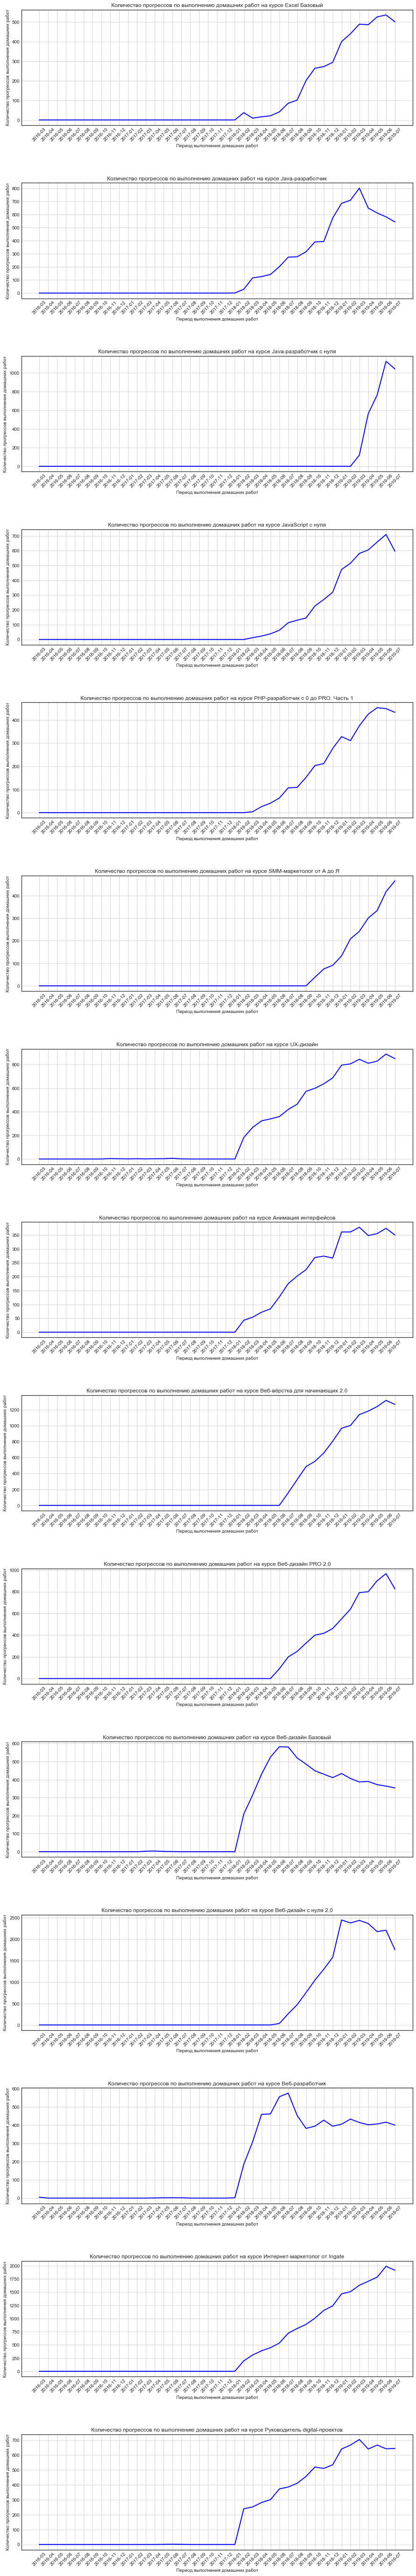

In [38]:
# Построение графиков 
fig, axes = plt.subplots(15, 1, figsize=(15, 100))
n = 0
for name, data in progress_graf.groupby('title'):
    datas = data.to_frame().reset_index().rename(columns={0 : 'hw_count', 'level_0' : 'ind'})
    datas['ind'] = pd.to_datetime(datas['ind']).dt.to_period('M')
    datas['ind'] = datas['ind'].astype(str)
    datas.index = datas['ind']
    datas = datas.drop('ind', axis='columns')
    axes[n].plot(datas.index, datas.hw_count, linewidth=2, color='b') 
    axes[n].set_xlabel('Период выполнения домашних работ')
    axes[n].set_ylabel('Количество прогрессов выполнения домашних работ')
    axes[n].set_title('Количество прогрессов по выполнению домашних работ на курсе {}'.format(name))
    axes[n].set_xticklabels(datas.index, rotation=45)
    axes[n].set_xticks(datas.index)
    axes[n].grid()
    n+=1
plt.subplots_adjust(wspace=0, hspace=0.5)
plt.show()   

#### 6. Построить один line-graph для всех курсов по четвертому пункту. 15 линий на графике. Ticks нужно развернуть так, чтобы они были читаемы. График должен иметь заголовок. Ось, отражающая количество прогрессов, должна быть подписана. Линия для каждого курса должна иметь свой цвет (нужна легенда). Рамок у графика быть не должно ⭐

In [39]:
graf_15 = progress_graf.to_frame().reset_index().rename(columns={0 : 'hw_count', 'level_0' : 'ind'})
graf_15['ind'] = pd.to_datetime(graf_15['ind']).dt.to_period('M')
graf_15['ind'] = graf_15['ind'].astype(str)
# сводная таблица по датафрейму 
piv_graf = graf_15.pivot_table(index='ind', columns='title', values='hw_count').fillna(0)
graf_15

ind                                title  hw_count
0    2016-03                        Excel Базовый         0
1    2016-03                     Java-разработчик         0
2    2016-03              Java-разработчик c нуля         0
3    2016-03                    JavaScript с нуля         0
4    2016-03  PHP-разработчик с 0 до PRO. Часть 1         0
..       ...                                  ...       ...
610  2019-07                   Веб-дизайн Базовый       354
611  2019-07                Веб-дизайн с нуля 2.0      1751
612  2019-07                      Веб-разработчик       400
613  2019-07        Интернет-маркетолог от Ingate      1914
614  2019-07        Руководитель digital-проектов       645

[615 rows x 3 columns]

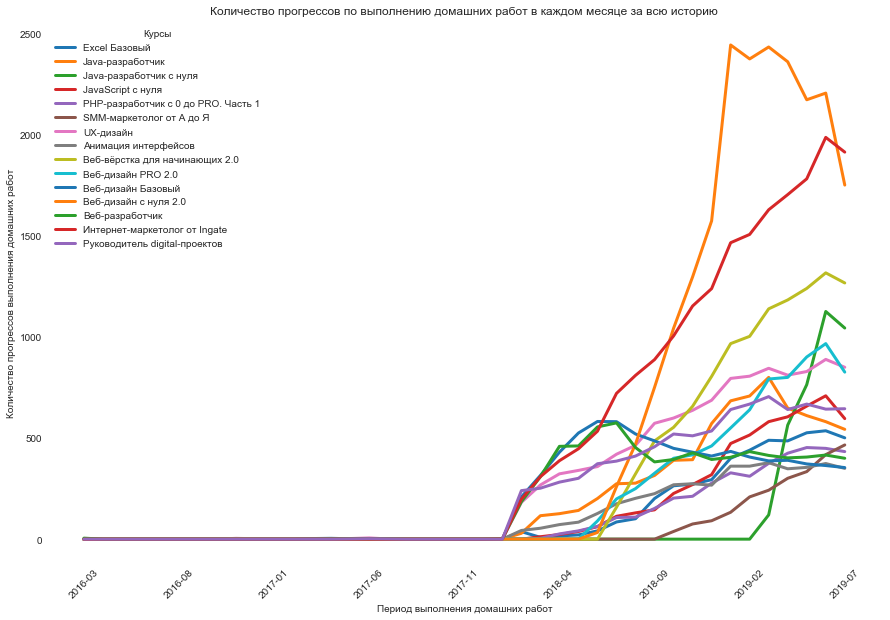

In [40]:
# Построение графиков
piv_graf.plot(figsize=(15,10), linewidth=3)
plt.xlabel('Период выполнения домашних работ')
plt.ylabel('Количество прогрессов выполнения домашних работ')
plt.title('Количество прогрессов по выполнению домашних работ в каждом месяце за всю историю')
plt.xticks(rotation=45)
plt.legend(loc='upper left', title='Курсы')
plt.box(False) # Удаление рамки
plt.show()

### На основании построенных графиков можно сделать следующие выводы о количетве домашних работ на каждом курсе и нагрузке на преподавателей:

1. Наиболее резкий рост количества домашних работ наблюдается на курсах Java разработчик с 0 и Веб-разработчик. Это обусловлено большим количеством студентов на этих курсах начавших учиться одновременно, а также большим количеством домашних заданий в курсе. Необходимо учитывать возможный резкий рост количества домашних работ и оптимизировать возможности преподавателей. 
2. Наибольшее количество ДЗ, а соответственно и нагрузка на преподавателей наблюдается на курсах Интернет - маркетолог от Ingate, Веб-дизайн с 0 2.0 и Веб-верстка для начинающих 2.0. Возможно эти  курсы являются наиболее науко-емкими и достаточно сложными для студентов и поэтому для выполнения домашних работ требуется более долгий период времени. И соответственно нагрузка на преподавателей на этих курсах становится более продолжительной. Также необходимо учесть количество квалифицированных преподавателей на этих курсах. Достаточно сложно найти необходимое количество преподавателей высокого уровня для проверки большого количества работ.
3. Судя по общему графику всех курсов количество домашних работ имеет тенденцию к уменьшению, но не резкому а плавному. Это обусловлено тем что часть студентов заканчивают обучение и получают диплом, а часть забрасывают обучение и перестают выполнять домашние работы.
4. В большинстве курсов наблюдается средняя нагрузка на преподавателей. Необходимо обратить внимание на курсы где количество домашних работ превышает 1000 работ в месяц, спрогнозировать рост количества работ на этих курсах и своевременно привлечь необходимое количество преподавателей для проверки домашних работ, чтобы избежать негативной обратной связи от студентов. 

### 3. Выявление проблемных модулей

#### 3.1   Рассчитать минимальное, максимальное, среднее, медианное время прохождения каждого модуля (разность между временем начала и окончания выполнения домашней работы) для каждого курса. Если домашних заданий в модуле несколько, то считать разность между временем начала выполнения первой домашней работы и временем окончания выполнения последней домашней работы в модуле

In [41]:
# Группировка датасэта по условию и удаление данных без даты окончания ДЗ
main_time =  main[main['is_homework'] == True].dropna()
main_time['start_date'] = pd.to_datetime(main_time['start_date'], errors='coerce')
main_time['finish_date'] = pd.to_datetime(main_time['finish_date'], errors='coerce')
# Создание дополнительный столбца с временем прохождения ДЗ в днях
main_time['diff'] = main_time.finish_date - main_time.start_date
main_time['diff'] = main_time['diff'].apply(lambda x: abs(int(x.days)))
# Создание дополнительный столбца с временем прохождения ДЗ в минутах
main_time['diff_min'] = main_time.finish_date - main_time.start_date
main_time['diff_min'] = main_time['diff_min'].apply(lambda x: int(x.total_seconds() // 60))
# Выборка по значением времени прохождения ДЗ > 0
time_min = main_time[main_time['diff_min'] > 0]
# Группировка и агрегирование для нахождения максимального, среднего и медианного значений времени прохождения ДЗ в днях
modules = time_min.groupby(['title','module_title'])['diff'].agg(['max','mean','median']).reset_index().rename(columns={'max' : 'max, дней', 'mean' : 'mean, дней', 'median' : 'median, дней'})
# Группировка и агрегирование для нахождения минимального значения времени прохождения ДЗ в минутах
modules_min = time_min.groupby(['title','module_title'])['diff_min'].agg('min').reset_index().rename(columns={'diff_min' : 'min, минут'})
# Итоговый датафрэйм со значениями времени прохождения ДЗ
module_time = modules.merge(modules_min, on=['module_title','title'], how='left')
module_time

title  \
0                    Excel Базовый   
1                    Excel Базовый   
2                    Excel Базовый   
3                    Excel Базовый   
4                    Excel Базовый   
..                             ...   
185  Руководитель digital-проектов   
186  Руководитель digital-проектов   
187  Руководитель digital-проектов   
188  Руководитель digital-проектов   
189  Руководитель digital-проектов   

                                          module_title  max, дней  mean, дней  \
0                            Визуализация данных Excel        174    9.615385   
1                            Основной функционал Excel        183    5.515419   
2              Основной функционал Excel (продолжение)        184    3.805970   
3                                Сводные таблицы Excel        239    9.215470   
4       Формулы и функции Excel. Более сложные формулы        175    6.921053   
..                                                 ...        ...         ...   
185                  Решение факапов. Lean/TOC. Обзор.        211   22.800000   
186                 Требовательность digital-продюсера        396   17.373887   
187                                Управление временем        163    7.603306   
188  Управление дизайнерами. Разработка дизайна по ...        199   16.089286   
189                         Экологичный путь менеджера        245    5.389091   

     median, дней  min, минут  
0             4.0         188  
1             2.0          52  
2             1.0          53  
3             2.0         183  
4             3.0          82  
..            ...         ...  
185           7.5         130  
186           7.0          60  
187           4.0          45  
188           8.5        1249  
189           2.0           4  

[190 rows x 6 columns]

#### 3.2  На основании первого пункта построить line-graph с медианным временем прохождения каждого модуля для каждого курса. 15 графиков. Графики должны иметь заголовки

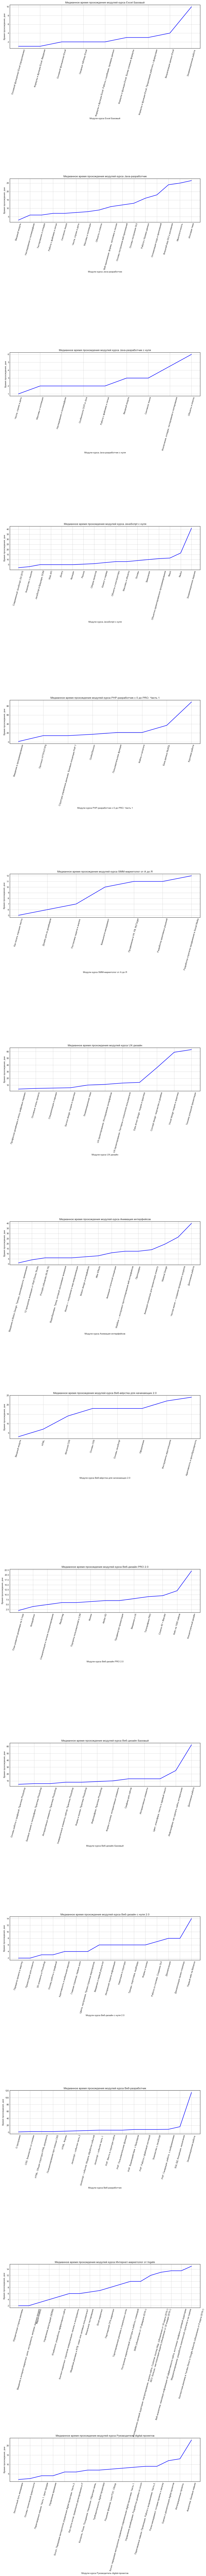

In [42]:
fig, axes = plt.subplots(15, 1, figsize=(15, 200))
n = 0
for name, data in module_time.groupby('title'):
    data = data.sort_values('median, дней')
    axes[n].plot(data['module_title'], data['median, дней'], linewidth=2, color='b')
    axes[n].set_xlabel('Модули курса {}'.format(name))
    axes[n].set_ylabel('Время прохождения, дни')
    axes[n].set_title('Медианное время прохождения модулей курса {}'.format(name))
    axes[n].set_xticks(data['module_title'])
    axes[n].set_xticklabels(data['module_title'],rotation=75)
    axes[n].grid()
    n+=1
    
plt.subplots_adjust(wspace=0, hspace=3)
plt.show()  

### На основании построенных графиков можно сделать следующие выводы:
1. Проблемными модулями, то есть модулями с долгим выполнением ДЗ, являются Веб-верстка для начинающих 2.0,
   UX-дизайн.Это возможно связано с обьемом каждого ДЗ на курсе, качеством ДЗ, понятностью ДЗ для студентов.
2. Время выпонения ДЗ изменяется от модуля к модулю. Первые модули и короткие модули (по количеству уроков)
   отнимают меньшее время на выполнение, а модули обьемные, и модули экзаменационные(дипломные) отнимают гораздо
   большее время на их выполнение. 
    

#### 3.3 Чтобы выявить сезонность, посчитать медианное время выполнения домашней работы по месяцам (12 месяцев, январь-декабрь) для каждого курса.

In [43]:
df_time = main_time[['title','module_title','start_date','finish_date','diff']]
# Создание столбца со значениями периодов выполнения ДЗ (DatetimeIndex) 
df_time["range"] = df_time.apply(lambda x: pd.date_range(x["start_date"], x["finish_date"]), axis=1)
# Создание столбца со значениями месяцев  выполения ДЗ (уникальные значения месяцев через множество)
df_time["months"] = df_time["range"].apply(lambda x: set(x.month.to_list()))
# Создание столбца со значениями месяцев (трансформация в список)
df_time["month"] = df_time["months"].apply(lambda x: list(x))
df_time

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] 

title  \
4                  Веб-дизайн PRO 2.0   
17      Интернет-маркетолог от Ingate   
29              Веб-дизайн с нуля 2.0   
37              Веб-дизайн с нуля 2.0   
38              Веб-дизайн с нуля 2.0   
...                               ...   
350640          Веб-дизайн с нуля 2.0   
350642          Веб-дизайн с нуля 2.0   
350659          Веб-дизайн с нуля 2.0   
350665  Интернет-маркетолог от Ingate   
350667  Интернет-маркетолог от Ingate   

                                             module_title  \
4                 Специализация и личное позиционирование   
17      Введение в интернет-маркетинг: цели, инструмен...   
29                               Основы работы с графикой   
37                        Адаптивность и мобильная версия   
38                                         Формы и кнопки   
...                                                   ...   
350640                        Введение и первый результат   
350642                    Работа со стилями. Создание GUI   
350659                       Тренды, подготовка, мудборды   
350665  Введение в интернет-маркетинг: цели, инструмен...   
350667  Исследование целевой аудитории: портретировани...   

                             start_date                      finish_date  \
4      2018-06-21 19:10:36.957891+00:00 2018-06-28 15:59:25.320418+00:00   
17     2018-02-19 12:30:34.638431+00:00 2018-02-20 09:16:50.297369+00:00   
29     2018-10-02 19:41:04.983571+00:00 2018-10-05 17:02:51.913911+00:00   
37     2019-01-14 15:59:10.737967+00:00 2019-01-23 06:22:01.837609+00:00   
38     2018-10-09 20:23:30.413974+00:00 2019-01-17 08:27:10.791105+00:00   
...                                 ...                              ...   
350640 2019-05-28 21:47:11.114080+00:00 2019-06-04 10:09:06.784550+00:00   
350642 2019-06-18 10:49:00.444537+00:00 2019-06-18 21:08:15.061297+00:00   
350659 2019-06-04 15:35:10.566121+00:00 2019-06-10 14:40:25.772859+00:00   
350665 2019-06-29 18:58:02.292673+00:00 2019-07-01 07:39:47.933005+00:00   
350667 2019-07-02 21:06:01.673478+00:00 2019-07-16 13:32:41.738515+00:00   

        diff                                              range  \
4          6  DatetimeIndex(['2018-06-21 19:10:36.957891+00:...   
17         0  DatetimeIndex(['2018-02-19 12:30:34.638431+00:...   
29         2  DatetimeIndex(['2018-10-02 19:41:04.983571+00:...   
37         8  DatetimeIndex(['2019-01-14 15:59:10.737967+00:...   
38        99  DatetimeIndex(['2018-10-09 20:23:30.413974+00:...   
...      ...                                                ...   
350640     6  DatetimeIndex(['2019-05-28 21:47:11.114080+00:...   
350642     0  DatetimeIndex(['2019-06-18 10:49:00.444537+00:...   
350659     5  DatetimeIndex(['2019-06-04 15:35:10.566121+00:...   
350665     1  DatetimeIndex(['2019-06-29 18:58:02.292673+00:...   
350667    13  DatetimeIndex(['2019-07-02 21:06:01.673478+00:...   

                 months            month  
4                   {6}              [6]  
17                  {2}              [2]  
29                 {10}             [10]  
37                  {1}              [1]  
38      {1, 10, 11, 12}  [1, 10, 11, 12]  
...                 ...              ...  
350640           {5, 6}           [5, 6]  
350642              {6}              [6]  
350659              {6}              [6]  
350665              {6}              [6]  
350667              {7}              [7]  

[44925 rows x 8 columns]

In [44]:
# Использование метода разложения списков в столбце month
month_df = df_time.explode('month')
# Группировка датафрэйма  по месяцам и названиям курсов
mediana = month_df.groupby(['month','title'])['diff'].agg('median').to_frame().reset_index()
mediana

month                                title  diff
0        1                        Excel Базовый   2.0
1        1                     Java-разработчик   8.0
2        1                    JavaScript с нуля   9.0
3        1  PHP-разработчик с 0 до PRO. Часть 1  27.5
4        1             SMM-маркетолог от А до Я  22.0
..     ...                                  ...   ...
166     12                   Веб-дизайн Базовый  61.5
167     12                Веб-дизайн с нуля 2.0   9.0
168     12                      Веб-разработчик  56.5
169     12        Интернет-маркетолог от Ingate  12.0
170     12        Руководитель digital-проектов  22.0

[171 rows x 3 columns]

In [45]:
# Формирование сводной таблицы
pivot_graf = mediana.pivot_table(index='month', columns='title', values='diff').fillna(0)
pivot_graf

title  Excel Базовый  Java-разработчик  Java-разработчик c нуля  \
month                                                             
1                2.0               8.0                      0.0   
2                3.0               8.0                      0.0   
3                3.0               8.0                      6.0   
4                2.0              18.0                      3.0   
5                3.0              27.0                      3.0   
6                3.0              19.0                      3.0   
7                2.0              12.5                      2.0   
8                3.0              20.0                      0.0   
9                2.0              20.0                      0.0   
10               2.0              19.0                      0.0   
11               3.0              13.0                      0.0   
12               5.0               6.0                      0.0   

title  JavaScript с нуля  PHP-разработчик с 0 до PRO. Часть 1  \
month                                                           
1                    9.0                                 27.5   
2                    9.0                                 46.5   
3                    8.0                                 23.5   
4                    8.0                                 16.0   
5                    8.0                                 15.5   
6                    8.0                                 16.0   
7                   10.0                                 10.0   
8                   10.0                                 20.0   
9                   12.5                                 19.0   
10                  15.0                                 27.0   
11                  16.0                                 46.5   
12                  16.0                                 37.5   

title  SMM-маркетолог от А до Я  UX-дизайн  Анимация интерфейсов  \
month                                                              
1                          22.0       33.5                  14.0   
2                          16.5       14.0                  10.0   
3                          13.0       19.0                  14.0   
4                          10.5       20.0                  18.0   
5                          12.0       17.0                  21.5   
6                           9.0       13.0                   9.0   
7                           7.0       15.0                   9.0   
8                           0.0       19.5                   9.0   
9                           0.0       23.0                  19.0   
10                         17.5       35.5                  15.0   
11                         20.5       36.0                  19.0   
12                         27.5       47.0                  33.0   

title  Веб-вёрстка для начинающих 2.0  Веб-дизайн PRO 2.0  Веб-дизайн Базовый  \
month                                                                           
1                                19.0                21.0                40.0   
2                                23.0                15.0                10.0   
3                                20.0                11.0                16.0   
4                                18.0                12.0                13.0   
5                                17.0                 9.0                11.0   
6                                12.0                 7.0                10.0   
7                                 5.0                12.0                12.0   
8                                 8.0                42.0                18.0   
9                                12.0                39.0                30.5   
10                               18.0                36.0                50.5   
11                               19.0                24.0                54.0   
12                               18.0                22.0                61.5   

title  Веб-дизайн с нуля 2.0  Веб-разработчик  Интернет-маркет

#### 3.4. На основании третьего пункта построить line-graph, на который будут нанесены линии для каждого курса с медианным временем выполнения домашней работы по месяцам. 15 линий на графике. График должен иметь заголовок. Ось, отражающая время прохождения, должна быть подписана. Линия для каждого курса должна иметь свой цвет (нужна легенда). Рамок у графика быть не должно ⭐

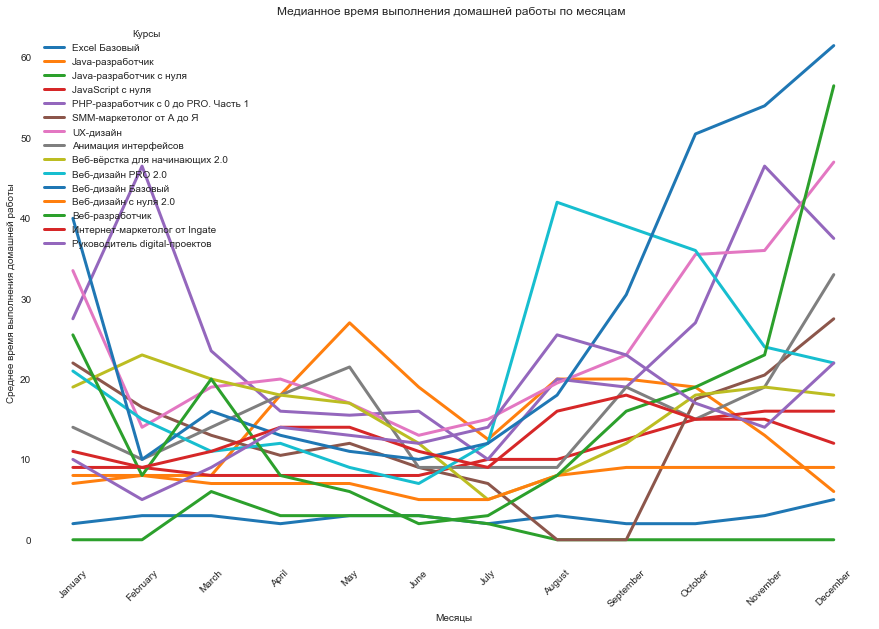

In [46]:
import calendar # импорт библиотеки calendar для преобразования целых чисел в названия месяцев
pivot_graf.plot(figsize=(15,10), linewidth=3)
plt.xlabel('Месяцы')
plt.ylabel('Среднее время выполнения домашней работы')
plt.title('Медианное время выполнения домашней работы по месяцам ')
# plt.xticks(pivot_graf.index, label = pivot_graf.index, rotation=45)
plt.xticks(pivot_graf.index, calendar.month_name[1:13], rotation=45)
plt.legend(loc='upper left', title='Курсы')
plt.box(False) # Удаление рамки
plt.show()

### На основании построенных графиков можно сделать следующие выводы:
1. Наблюдается тенденция к выраженной сезонности обучения. В летние месяцы (июнь, июль, август) наблюдается снижение активности обучения. Студенты мало тратят времени на обучение и соответственно мало выполняют ДЗ , хотя как в осенние и  зимние  месяцы активность обучения значительно возрастает и начинает спадать в весенние месяцы. Эта тенденция присуща больщинству курсов.

### 4. Посчитать конверсию перехода студентов из одного модуля в другой на каждом курсе. Формула: отношение количества студентов, приступивших к выполнению домашнего задания в этом модуле (если дз в модуле несколько, то считать по первому дз в модуле), к количеству студентов, сдавших задание в предыдущем модуле (если дз в модуле несколько, то считать по последнему дз в модуле).

In [47]:
# Сортировка по уроку
conver =  main[main['is_homework'] == True]

In [48]:
# определение модулей с несколькими ДЗ
mod = conver.groupby(['title','module_title','lesson_title'])['lesson_token'].nunique().reset_index().sort_values('lesson_token', ascending=False)
mod.head(5)

title  \
35   Java-разработчик c нуля   
32   Java-разработчик c нуля   
26   Java-разработчик c нуля   
34   Java-разработчик c нуля   
129       Веб-дизайн Базовый   

                                         module_title     lesson_title  \
35                           Работа с файлами и сетью  Домашняя работа   
32                         Наследование и полиморфизм  Домашняя работа   
26   Исключения, отладка, тестирование и логгирование  Домашняя работа   
34                             Особенности ООП в Java  Домашняя работа   
129                   Инфографика. Практика Photoshop  Домашняя работа   

     lesson_token  
35              5  
32              4  
26              3  
34              2  
129             1

In [49]:
# Определение номеров уроков и выявление первого урока с ДЗ в модуле 'Особенности ООП в Java'
mod_hw = conver[(conver['title'] == 'Java-разработчик c нуля') & (conver['module_title'] == 'Особенности ООП в Java')]['lesson_number'].unique()
mod_hw

array([8, 2])

In [50]:
# удаление строк с лишними ДЗ в модуле:
# Остается только урок с первой домашней работой модуля 'Особенности ООП в Java' (урок 2)
df_trim = conver.drop(conver[(conver['lesson_number'] == 8) & (conver['title'] == 'Java-разработчик c нуля') & (conver['module_title'] == 'Особенности ООП в Java')].index)
# удаление строк с лишними ДЗ в модуле:
# Остается только урок с последней домашней работой модуля 'Особенности ООП в Java' (урок 8)
df_trim_finish = conver.drop(conver[(conver['lesson_number'] == 2) & (conver['title'] == 'Java-разработчик c нуля') & (conver['module_title'] == 'Особенности ООП в Java')].index)

In [51]:
# Определение номеров уроков и выявление первого урока с ДЗ в модуле 'Исключения, отладка, тестирование и логгирование'
mod_hw_2 = conver[(conver['title'] == 'Java-разработчик c нуля') & (conver['module_title'] == 'Исключения, отладка, тестирование и логгирование')]['lesson_number'].unique()
mod_hw_2

array([ 4,  8, 11])

In [52]:
# удаление строк с лишними ДЗ в модуле:
# Остается только урок с первой домашней работой модуля 'Исключения, отладка, тестирование и логгирование' (урок 4)
df_trim_2 = df_trim.drop(df_trim[((df_trim['lesson_number'] == 8) | (df_trim['lesson_number'] == 11)) & (df_trim['title'] == 'Java-разработчик c нуля') & (df_trim['module_title'] == 'Исключения, отладка, тестирование и логгирование')].index)
# удаление строк с лишними ДЗ в модуле:
# Остается только урок с последней домашней работой модуля 'Исключения, отладка, тестирование и логгирование' (урок 11)
df_trim_finish_2 = df_trim_finish.drop(df_trim_finish[((df_trim_finish['lesson_number'] == 8) | (df_trim_finish['lesson_number'] == 4)) & (df_trim_finish['title'] == 'Java-разработчик c нуля') & (df_trim_finish['module_title'] == 'Исключения, отладка, тестирование и логгирование')].index)

In [53]:
# Определение номеров уроков и выявление первого урока с ДЗ в модуле 'Наследование и полиморфизм'
mod_hw_3 = df_trim[(df_trim['title'] == 'Java-разработчик c нуля') & (df_trim['module_title'] == 'Наследование и полиморфизм')]['lesson_number'].unique()
mod_hw_3

array([ 2,  6,  4, 13])

In [54]:
# удаление строк с лишними ДЗ в модуле:
# Остается только ДЗ с первой домашней работой модуля 'Наследование и полиморфизм' (урок 2)
df_trim_3 = df_trim_2.drop(df_trim_2[((df_trim_2['lesson_number'] == 6) | (df_trim_2['lesson_number'] == 4) | (df_trim_2['lesson_number'] == 13)) & (df_trim_2['title'] == 'Java-разработчик c нуля') & (df_trim_2['module_title'] == 'Наследование и полиморфизм')].index)
# удаление строк с лишними ДЗ в модуле:
# Остается только урок с последней домашней работой модуля 'Наследование и полиморфизм' (урок 13)
df_trim_finish_3 = df_trim_finish_2.drop(df_trim_finish_2[((df_trim_finish_2['lesson_number'] == 6) | (df_trim_finish_2['lesson_number'] == 4) | (df_trim_finish_2['lesson_number'] == 2)) & (df_trim_finish_2['title'] == 'Java-разработчик c нуля') & (df_trim_finish_2['module_title'] == 'Наследование и полиморфизм')].index)


In [55]:
# Определение номеров уроков и выявление первого урока с ДЗ в модуле 'Работа с файлами и сетью'
mod_hw_4 = df_trim[(df_trim['title'] == 'Java-разработчик c нуля') & (df_trim['module_title'] == 'Работа с файлами и сетью')]['lesson_number'].unique()
mod_hw_4

array([ 7, 12,  5,  9, 14])

In [56]:
# удаление строк с лишними ДЗ в модуле:
# Остается только ДЗ с первой домашней работой модуля 'Работа с файлами и сетью' (урок 5)
df_trim_4 = df_trim_3.drop(df_trim_3[((df_trim_3['lesson_number'] == 7) | (df_trim_3['lesson_number'] == 12) | (df_trim_3['lesson_number'] == 9) | (df_trim_3['lesson_number'] == 14)) & (df_trim_3['title'] == 'Java-разработчик c нуля') & (df_trim_3['module_title'] == 'Работа с файлами и сетью')].index)
# удаление строк с лишними ДЗ в модуле:
# Остается только урок с последней домашней работой модуля 'Работа с файлами и сетью' (урок 14)
df_trim_finish_4 = df_trim_finish_3.drop(df_trim_finish_3[((df_trim_finish_3['lesson_number'] == 7) | (df_trim_finish_3['lesson_number'] == 12) | (df_trim_finish_3['lesson_number'] == 9) | (df_trim_finish_3['lesson_number'] == 5)) & (df_trim_finish_3['title'] == 'Java-разработчик c нуля') & (df_trim_finish_3['module_title'] == 'Работа с файлами и сетью')].index)

In [57]:
# Создание датафрэйма с количеством студентов начавших ДЗ модуля
conv_start = df_trim_4.groupby(['title','module_title','module_number'])['start_date'].count().reset_index()
# Создание датафрэйма с количеством студентов закончивших ДЗ модуля
conv_finish = df_trim_finish_4.groupby(['title','module_title','module_number'])['finish_date'].count().reset_index()
# Создание общего датафрэйма
conv_merge = conv_start.merge(conv_finish, on=['title','module_title','module_number'])
conv_merge

title  \
0                    Excel Базовый   
1                    Excel Базовый   
2                    Excel Базовый   
3                    Excel Базовый   
4                    Excel Базовый   
..                             ...   
186  Руководитель digital-проектов   
187  Руководитель digital-проектов   
188  Руководитель digital-проектов   
189  Руководитель digital-проектов   
190  Руководитель digital-проектов   

                                          module_title  module_number  \
0                            Визуализация данных Excel              7   
1                            Основной функционал Excel              1   
2              Основной функционал Excel (продолжение)              2   
3                                Сводные таблицы Excel              8   
4       Формулы и функции Excel. Более сложные формулы              5   
..                                                 ...            ...   
186                  Решение факапов. Lean/TOC. Обзор.             12   
187                 Требовательность digital-продюсера              3   
188                                Управление временем              9   
189  Управление дизайнерами. Разработка дизайна по ...             14   
190                         Экологичный путь менеджера              1   

     start_date  finish_date  
0           238          200  
1           518          458  
2           434          406  
3           202          186  
4           298          270  
..          ...          ...  
186          95           88  
187         402          345  
188         136          129  
189          71           64  
190         598          560  

[191 rows x 5 columns]

#### 4.2 Постройте bar-chart, отражающий конверсию перехода студентов из одного модуля в другой на каждом курсе. График должен иметь заголовок. Ticks нужно развернуть так, чтобы они были читаемы

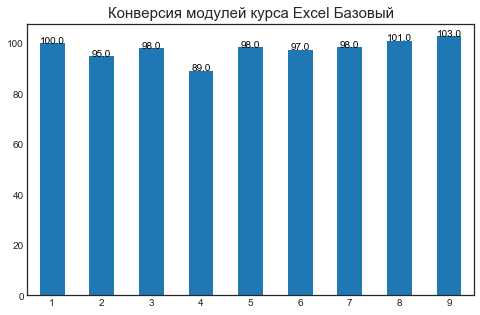

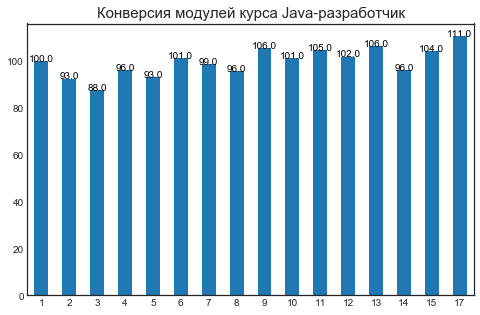

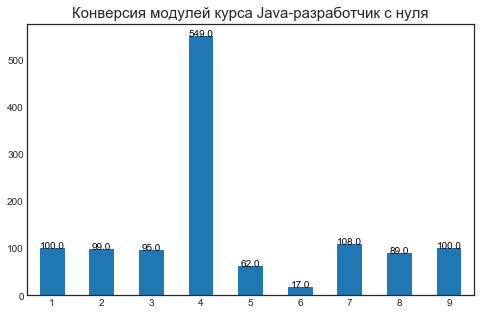

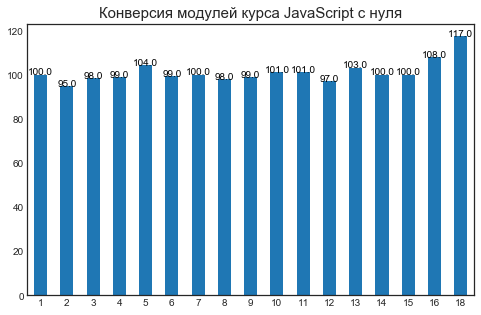

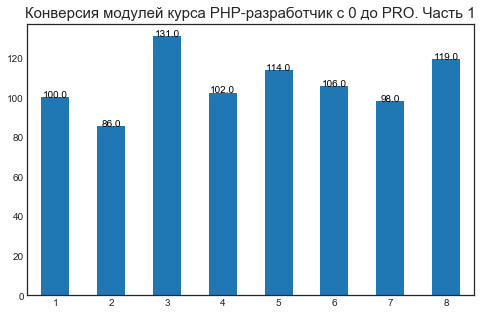

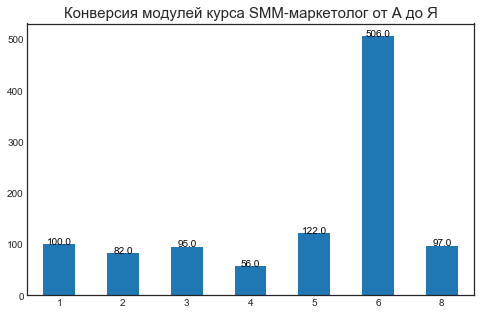

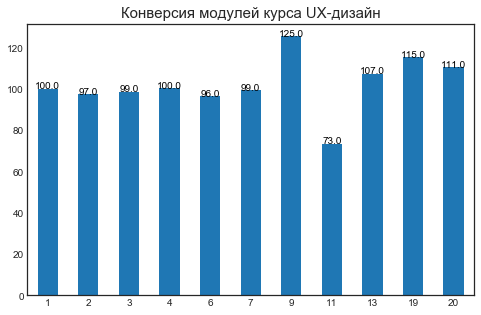

posx and posy should be finite values
posx and posy should be finite values


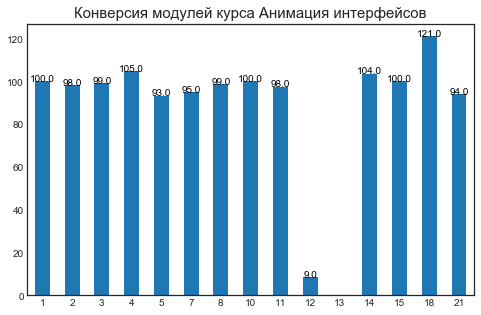

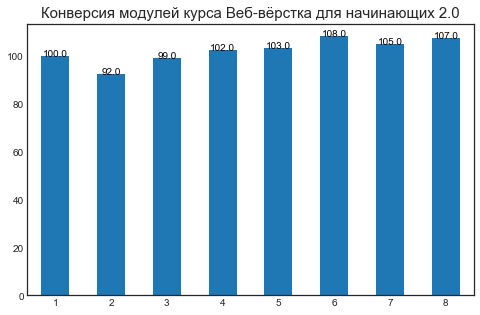

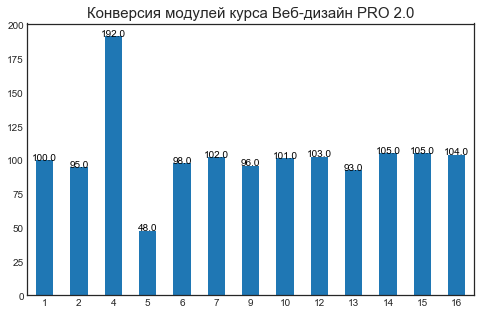

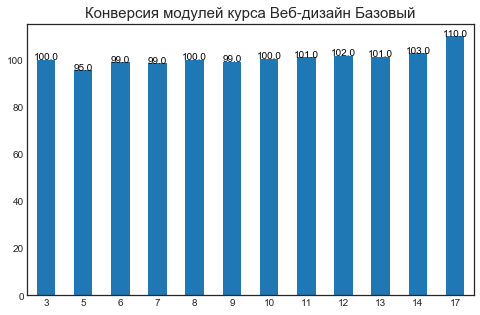

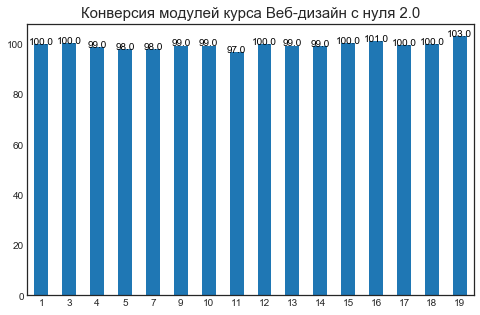

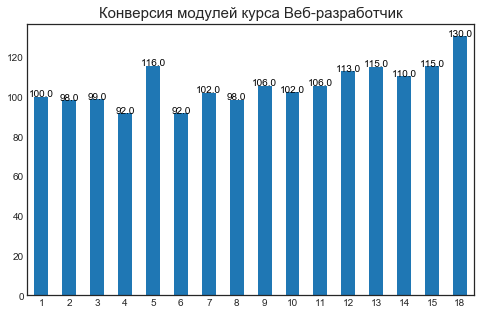

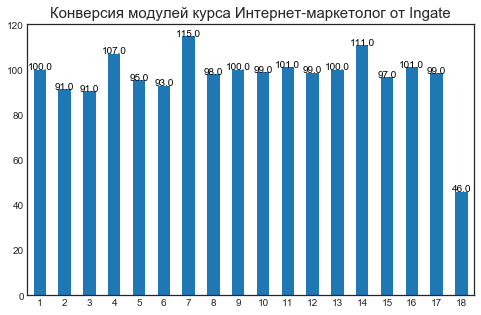

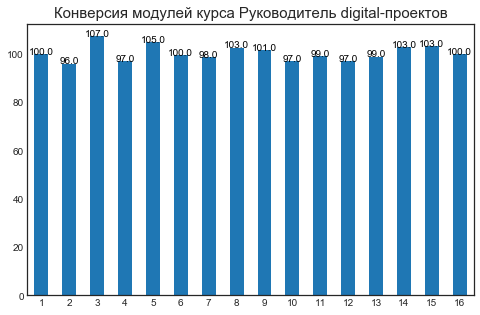

In [58]:
# Расчет конверсии в каждом курсе
for name, data in conv_merge.groupby('title'):
    # Сортировка модулей в каждом курсе
    datas = data.sort_values('module_number')
    # Создание дополнительного столбца со смещением данных на 1 строку 
    datas['shift'] = datas['finish_date'].shift(periods=1)
    # Расчет конверсии по формуле
    datas['converse'] = (datas['start_date']/datas['shift'])*100
    # Замена отсутствующих значений конверсии в первом модуле(составляет 100%)
    datas['converse'] = datas['converse'].fillna(100)
    dat = datas.reset_index().drop('index',axis='columns')
    # конверсия по каждому курсу
    dat = dat[['module_number','converse']]
    # Построение графиков для каждого курса
    plot = dat.plot.bar(x='module_number',y='converse'
                          ,figsize=(8,5)
                          ,fontsize=10
                          ,legend = False
                          ,title=('Конверсия модулей курса {}'.format(name)))
    # указание значений конверсии для каждого модуля
    for index, row in dat.iterrows():
        plot.text(row.name, row.converse, round(row.converse), color='black', ha="center")
    plot.title.set_size(15)
    plot.set(ylabel=None, xlabel=None)
    plot.set_xticklabels(labels=dat['module_number'],rotation=0)
    plt.show()


#### 4.3  Постройте горизонтальный (столбцы должны располагаться горизонтально) bar-chart, отражающий конверсию перехода студентов из одного модуля в другой на каждом курсе. 15 графиков. Графики должны иметь заголовки. Ticks должны содержать номер и название модуля. Цвет столбцов графиков должен содержать информацию о сфере, к которой относится курс (нужна легенда). Прозрачность должна стоять на отметке 0.1. На графики должна быть нанесена линия медианы конверсии для каждого курса. У медианы должен быть свой цвет. Рамок у графиков быть не должно ⭐

In [59]:
# Создание датафрэйма с количеством студентов начавших ДЗ модуля c указанием направления:
df_start = df_trim_4.groupby(['field','title','module_title','module_number'])['start_date'].count().reset_index()
# Создание датафрэйма с количеством студентов закончивших ДЗ модуля с указанием направления:
df_finish = conv_finish = df_trim_finish_4.groupby(['field','title','module_title','module_number'])['finish_date'].count().reset_index()

conv_df = df_start.merge(df_finish, on=['title','module_title','module_number','field'])



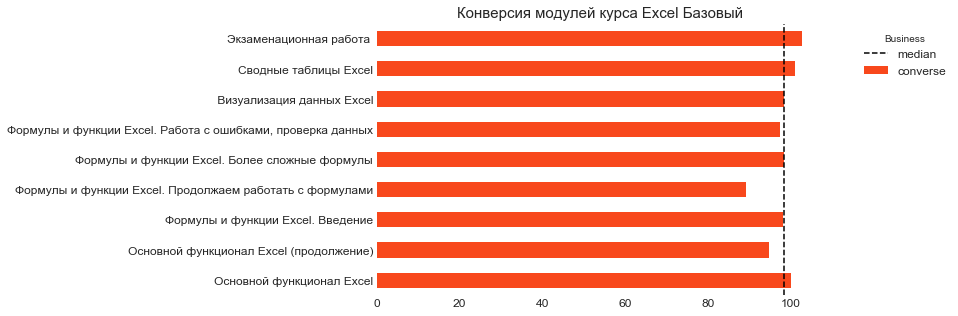

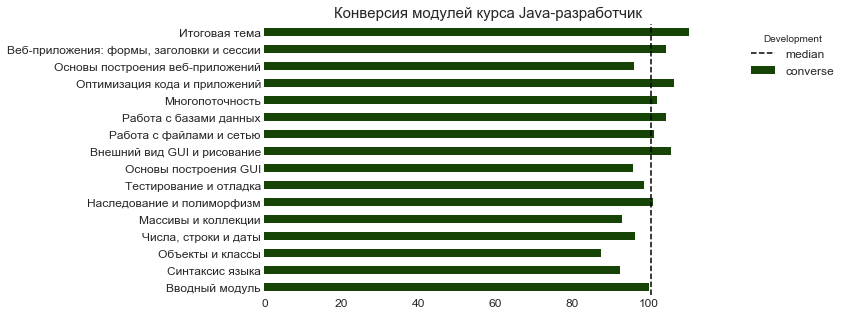

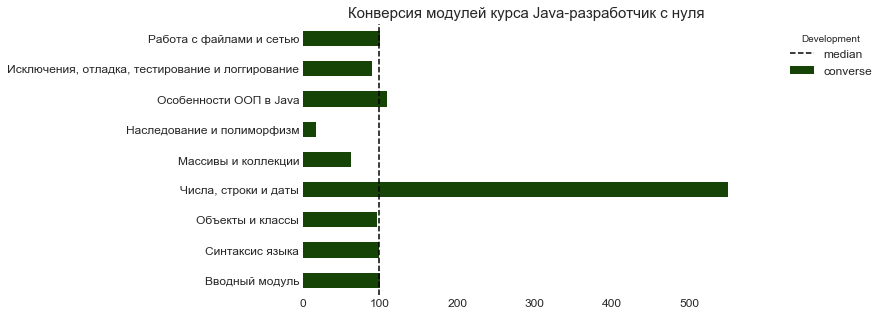

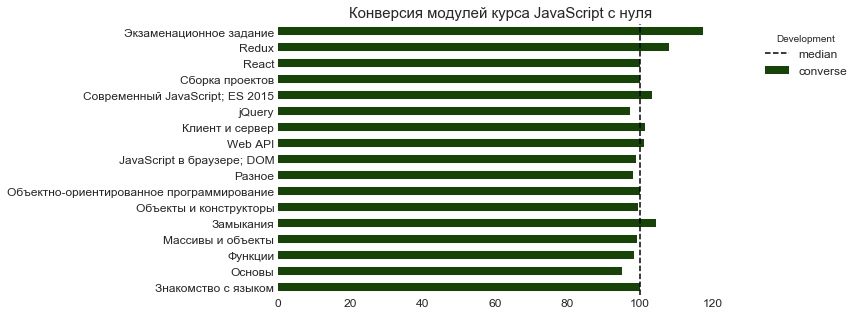

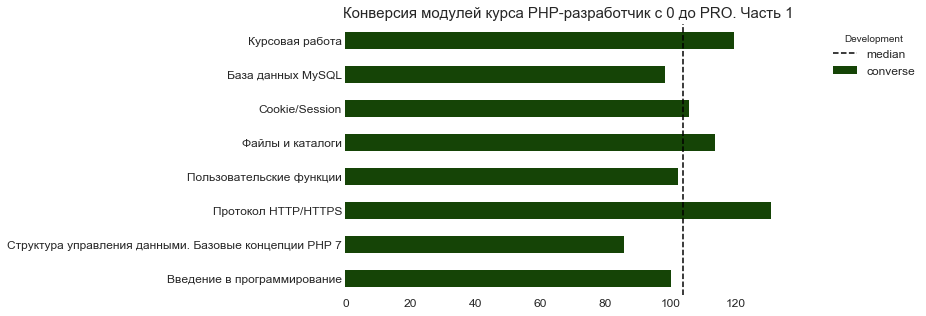

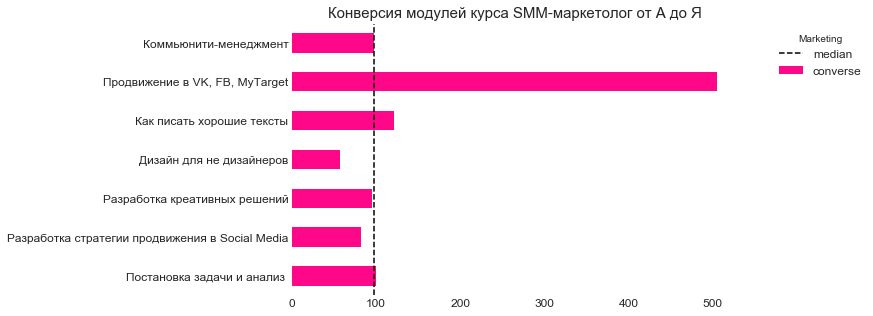

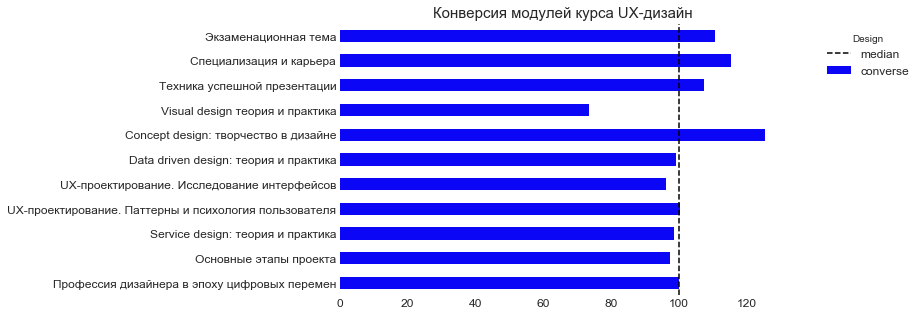

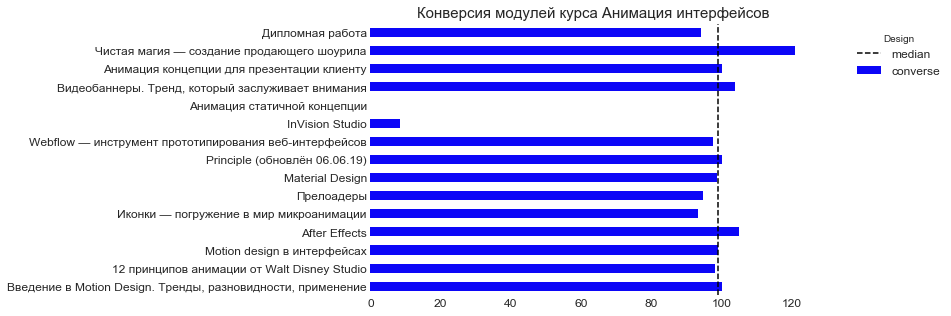

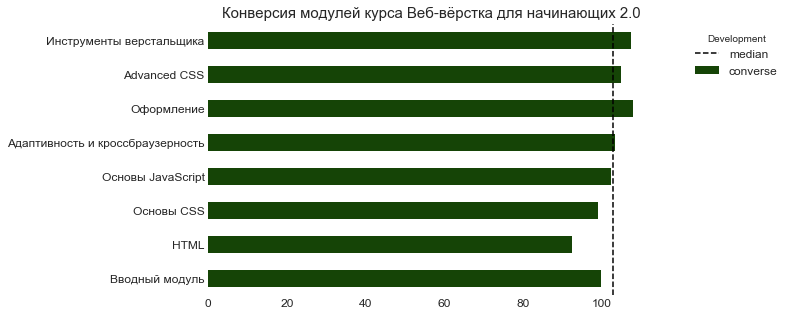

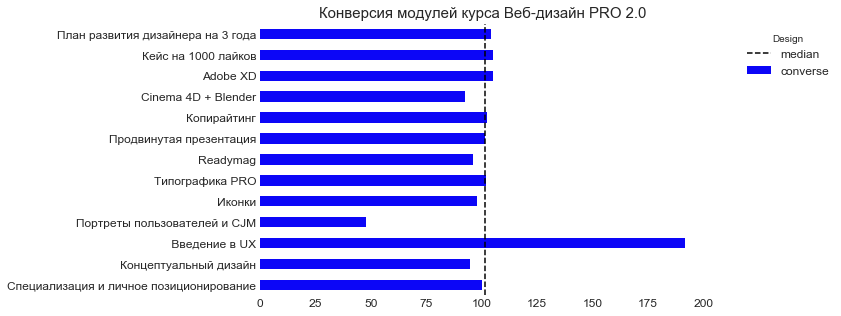

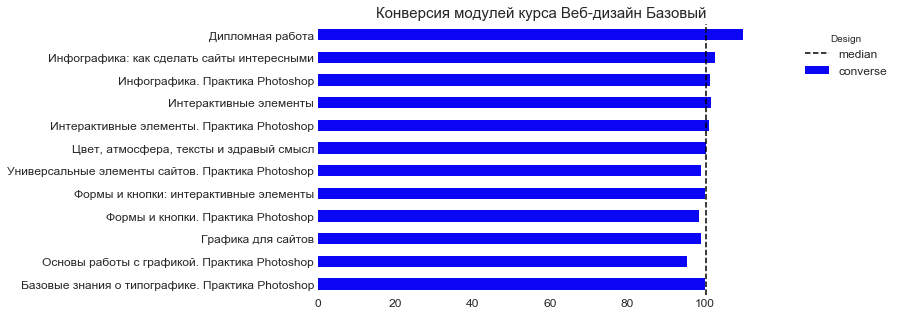

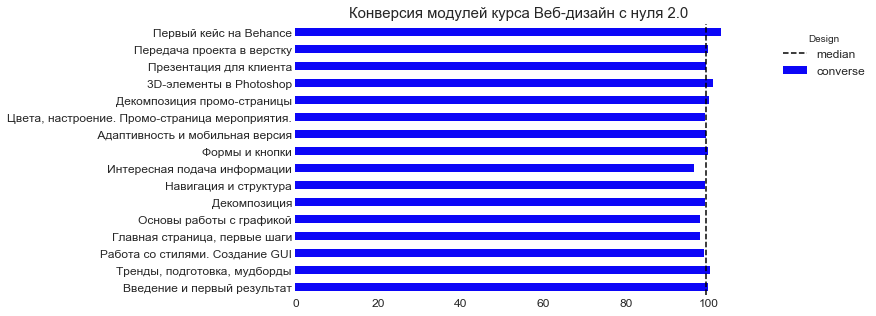

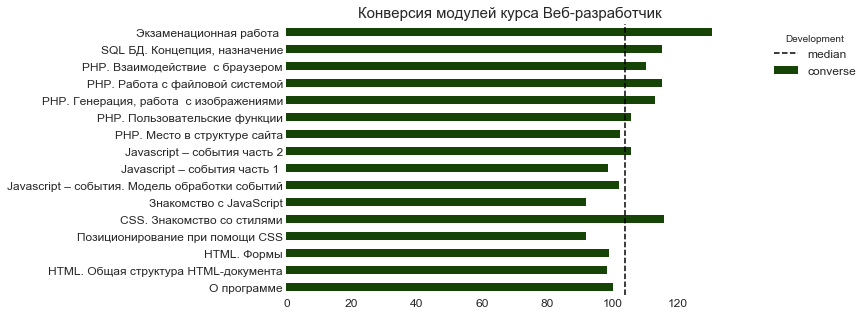

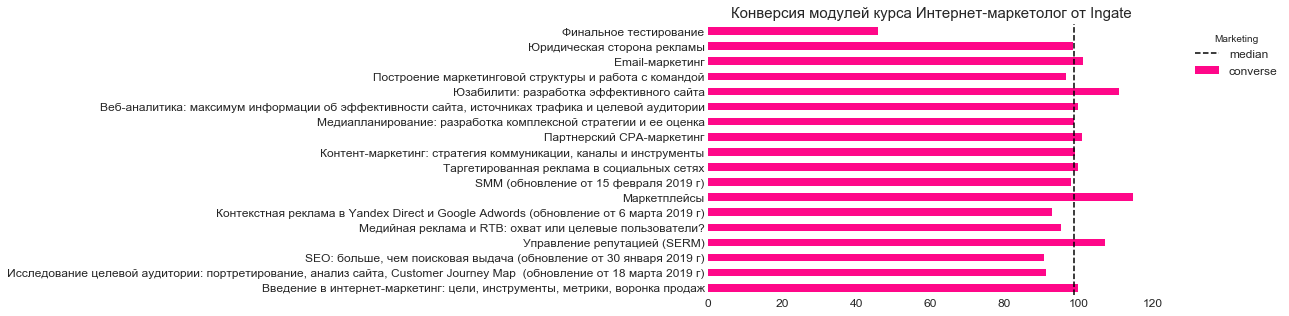

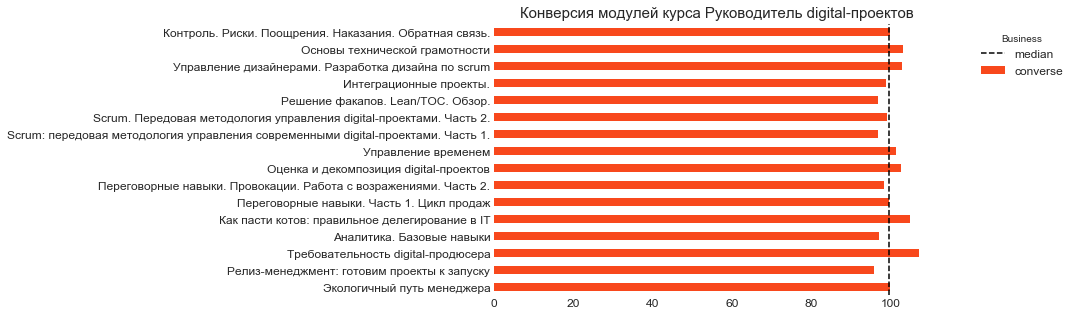

In [60]:
import matplotlib
colors = matplotlib.colors.get_named_colors_mapping()
list(colors.keys())[:10]
color_map = {'Business' : colors['xkcd:reddish orange'],
             'Design' : colors['xkcd:strong blue'],
             'Development' : colors['xkcd:forrest green'],
             'Marketing' : colors['xkcd:strong pink']}
for name, data in conv_df.groupby(['title']):
    # Сортировка модулей в каждом курсе
    datas = data.sort_values('module_number')
    # Создание дополнительного столбца со смещением данных на 1 строку 
    datas['shift'] = datas['finish_date'].shift(periods=1)
    # Расчет конверсии по формуле
    datas['converse'] = (datas['start_date']/datas['shift'])*100
    # Замена отсутствующих значений конверсии в первом модуле(составляет 100%)
    datas['converse'] = datas['converse'].fillna(100)
    dat = datas.reset_index().drop('index',axis='columns')
    # конверсия по каждому курсу
    dat = dat[['field','module_title','converse']]
    c = dat['field'].to_list()[0]
    mediana_conv = dat['converse'].median()
    plot = dat.plot.barh(x='module_title', y='converse', figsize=(8,5),fontsize=12, title=('Конверсия модулей курса {}'.format(name)),
                         color=color_map[c])
    plot.axvline(x=mediana_conv, ls='--', color='black', label='median') # Построение медианы конверсии на каждом курсе
    plot.legend(loc=1, bbox_to_anchor=(1.3, 1), fontsize=12, title=c) # Построение легенды
    sns.despine(left=True, bottom=True, right=True)
    plot.title.set_size(15)
    plot.set(ylabel=None, xlabel=None)
    plt.show()

#### На основании построенных графиков можно сделать следующие выводы:
1. Конверсия перехода из модуля в модуль на всех курсах составляет около 100% в среднем. Небольшие отклонения обусловлены некоторыми особенносями модулей в курсах.
2. В курсе Анимация интерфейсов ДЗ модуля " Анимация статичной концепции" не сдал ни один студент. В модуле "InVision Studio" ДЗ сдали порядка 10% студентов. Необходимо оьратить на качество преподаваемого материала и сложность ДЗю
3. В курсе SMM-маркетолог от А до Я конверсия модуля "Продвижение в VK, FB, MyTarget" составляет порядка 500%. Это обусловлено тем что данный модуль курса очень востребован и студенты не заканчивают модуль "Коммьюнити-менеджмент" и сразу приступают к модулю  "Продвижение в VK, FB, MyTarget".
4. Более устойчивая конверсия наблюдается на курсах в сфере Менеджмента